In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision.utils import make_grid
# import torchvision.utils as vutils
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import math
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

In [2]:
df = pd.read_csv("train.csv")

In [3]:
len(df)

42000

In [4]:
df['label'].value_counts()

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

In [5]:
# Find the maximum number of occurrences of any digit
max_size = df['label'].value_counts().max()

# Use pd.concat to create a list of dataframes to be concatenated
frames = [df]  # Start with the original dataframe

# Loop through each class group and append necessary duplicates
for class_index, group in df.groupby('label'):
    samples_to_add = max_size - len(group)
    if samples_to_add > 0:
        frames.append(group.sample(samples_to_add, replace=True))

# Concatenate all the frames together and shuffle the dataframe
df = pd.concat(frames).sample(frac=1).reset_index(drop=True)

# Check the new value counts to confirm balancing
print(df['label'].value_counts())

label
2    4684
8    4684
3    4684
9    4684
6    4684
5    4684
4    4684
0    4684
1    4684
7    4684
Name: count, dtype: int64


In [6]:
# 1 represents real, 0 fake
df['label'] = 1

In [7]:
X_discriminator = df.drop('label', axis=1)
y_discriminator = torch.tensor(df['label'].values, dtype=torch.float32)

In [8]:
pixel_columns = df.shape[1] - 1  # subtracting 1 for the label column

image_side_length = int(pixel_columns**0.5)
print(f"Each image is {image_side_length}x{image_side_length} pixels.")

Each image is 28x28 pixels.


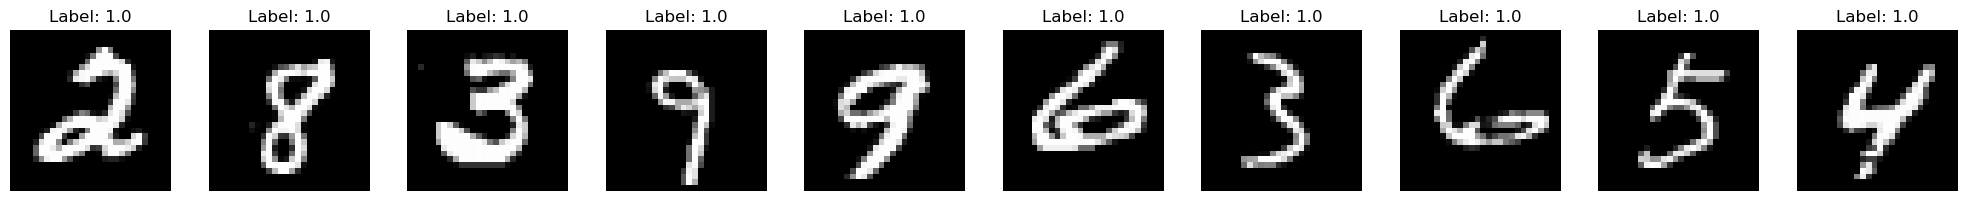

In [9]:
fig, axes = plt.subplots(1, 10, figsize=(20, 2))  
for i, ax in enumerate(axes):
    # Reshape each row into 28x28 array and plot
    img = X_discriminator.iloc[i].to_numpy().reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {y_discriminator[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()

In [10]:
X_discriminator = X_discriminator.values.reshape(-1, 1, 28, 28)
X_discriminator = (torch.tensor(X_discriminator).float() / 255.0) * 2 - 1

In [11]:
dataset_discriminator = TensorDataset(X_discriminator, y_discriminator)
loader_discriminator = DataLoader(dataset_discriminator, batch_size=64, shuffle=True)

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(in_features=128*7*7, out_features=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(F.relu(self.conv5(x)))

        x = F.relu(self.conv6(x))
        x = x.view(-1, 128*7*7)
        x = self.dropout(x)
        x = self.fc(x)
        return torch.sigmoid(x)

In [13]:
class Generator(nn.Module):
    def __init__(self, noise_dim):
        super(Generator, self).__init__()
        self.fc = nn.Linear(in_features=noise_dim, out_features=noise_dim) # (1, 49) -> (1, 7, 7)
        self.convT1 = nn.ConvTranspose2d(in_channels=1, out_channels=128, kernel_size=4, stride=1)  # (1, 7, 7) -> (1, 10, 10)
        self.bn1 = nn.BatchNorm2d(num_features=128)
        self.convT2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2) # (1, 10, 10) -> (1, 22, 22)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.convT3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1) # (1, 22, 22) -> (1, 24, 24)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.convT4 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1) # (1, 24, 24) -> (1, 26, 26)
        self.bn4 = nn.BatchNorm2d(num_features=16)
        self.dropout = nn.Dropout(0.3)
        self.convT5 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=1) # (1, 26, 26) -> (1, 28, 28)

    def forward(self, x):
        x = F.leaky_relu(self.fc(x))
        x = x.view(-1, 1, int(math.sqrt(noise_dim)), int(math.sqrt(noise_dim)))
        x = F.relu(self.bn1(self.convT1(x)))
        x = F.relu(self.bn2(self.convT2(x)))
        x = F.relu(self.bn3(self.convT3(x)))
        x = F.relu(self.bn4(self.convT4(x)))
        x = self.dropout(x)
        x = torch.tanh(self.convT5(x))
        return x

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

noise_dim = 49
generator = Generator(noise_dim=noise_dim).to(device)
discriminator = Discriminator().to(device)

optim_G = torch.optim.Adam(generator.parameters(), lr=0.0001024, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001024, betas=(0.5, 0.999))
scheduler_G = StepLR(optimizer=optim_G, step_size=20, gamma=0.8)
scheduler_D = StepLR(optimizer=optim_D, step_size=20, gamma=0.8)

100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.30it/s, loss_D=1.01, loss_G=1.24]


Epoch [1/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [1/200] - Average D loss: 0.7982, Average G loss: 1.7810


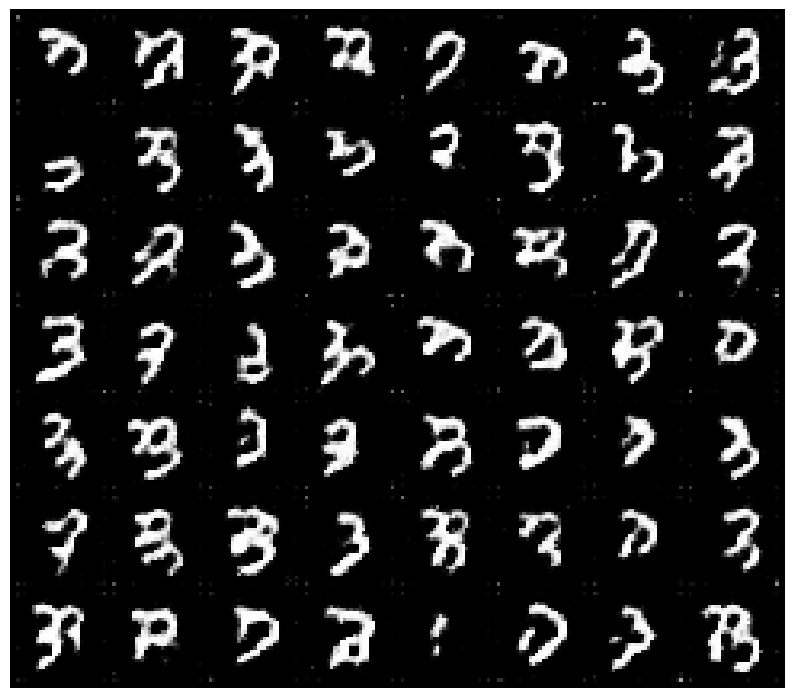

100%|█████████████████████████████████████████████████████| 732/732 [00:46<00:00, 15.61it/s, loss_D=1.23, loss_G=0.817]


Epoch [2/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [2/200] - Average D loss: 1.1853, Average G loss: 1.0263


100%|██████████████████████████████████████████████████████| 732/732 [00:46<00:00, 15.59it/s, loss_D=1.19, loss_G=0.79]


Epoch [3/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [3/200] - Average D loss: 1.2003, Average G loss: 0.9218


100%|██████████████████████████████████████████████████████| 732/732 [00:46<00:00, 15.60it/s, loss_D=1.03, loss_G=1.07]


Epoch [4/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [4/200] - Average D loss: 1.1316, Average G loss: 1.0082


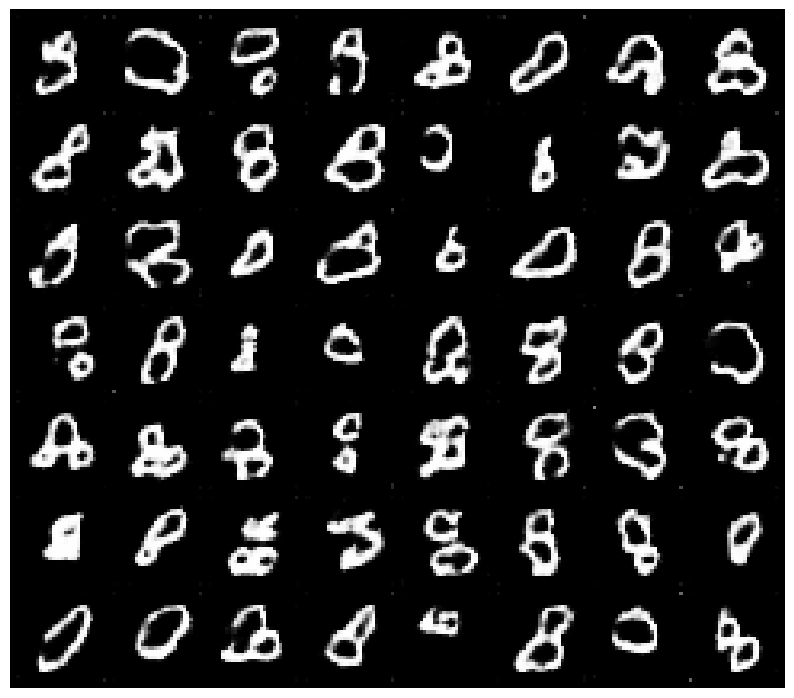

100%|█████████████████████████████████████████████████████| 732/732 [00:46<00:00, 15.58it/s, loss_D=1.03, loss_G=0.932]


Epoch [5/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [5/200] - Average D loss: 1.0980, Average G loss: 1.0463


100%|███████████████████████████████████████████████████████| 732/732 [00:46<00:00, 15.59it/s, loss_D=1.04, loss_G=1.2]


Epoch [6/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [6/200] - Average D loss: 1.0630, Average G loss: 1.0915


100%|█████████████████████████████████████████████████████| 732/732 [00:46<00:00, 15.60it/s, loss_D=0.932, loss_G=1.38]


Epoch [7/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [7/200] - Average D loss: 1.0227, Average G loss: 1.1533


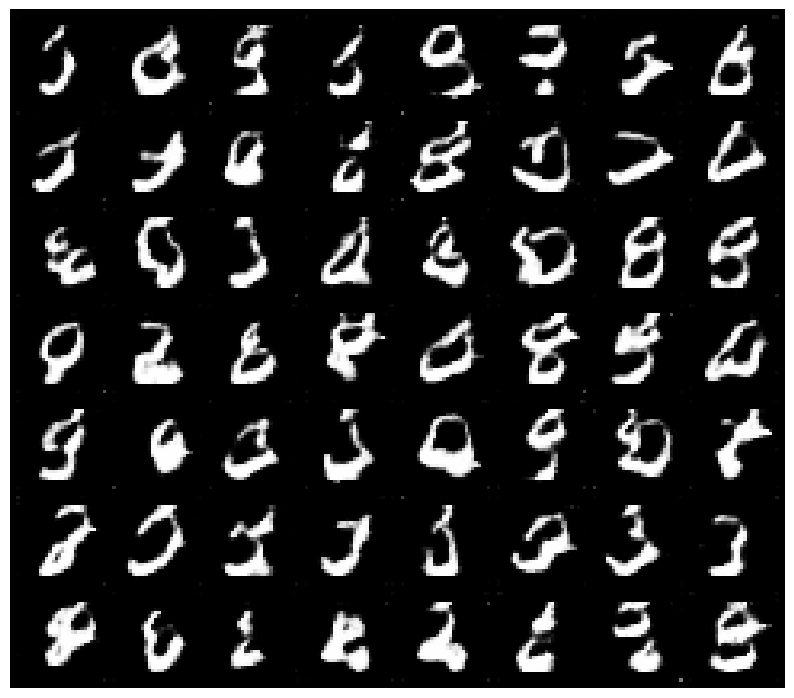

100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.55it/s, loss_D=0.948, loss_G=1.1]


Epoch [8/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [8/200] - Average D loss: 1.0357, Average G loss: 1.1715


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.56it/s, loss_D=1.01, loss_G=0.764]


Epoch [9/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [9/200] - Average D loss: 1.0635, Average G loss: 1.1129


100%|█████████████████████████████████████████████████████| 732/732 [00:46<00:00, 15.58it/s, loss_D=1.07, loss_G=0.993]


Epoch [10/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [10/200] - Average D loss: 1.0493, Average G loss: 1.1392


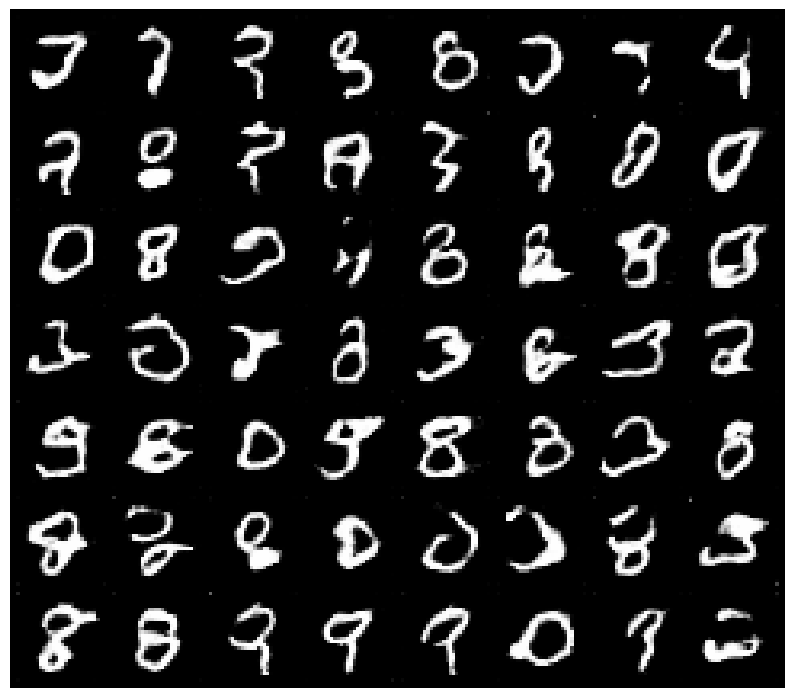

100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.54it/s, loss_D=1.14, loss_G=1.61]


Epoch [11/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [11/200] - Average D loss: 1.0253, Average G loss: 1.1818


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.53it/s, loss_D=0.938, loss_G=1.43]


Epoch [12/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [12/200] - Average D loss: 0.9996, Average G loss: 1.2171


100%|██████████████████████████████████████████████████████| 732/732 [00:46<00:00, 15.58it/s, loss_D=0.836, loss_G=1.5]

Epoch [13/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [13/200] - Average D loss: 0.9686, Average G loss: 1.2848


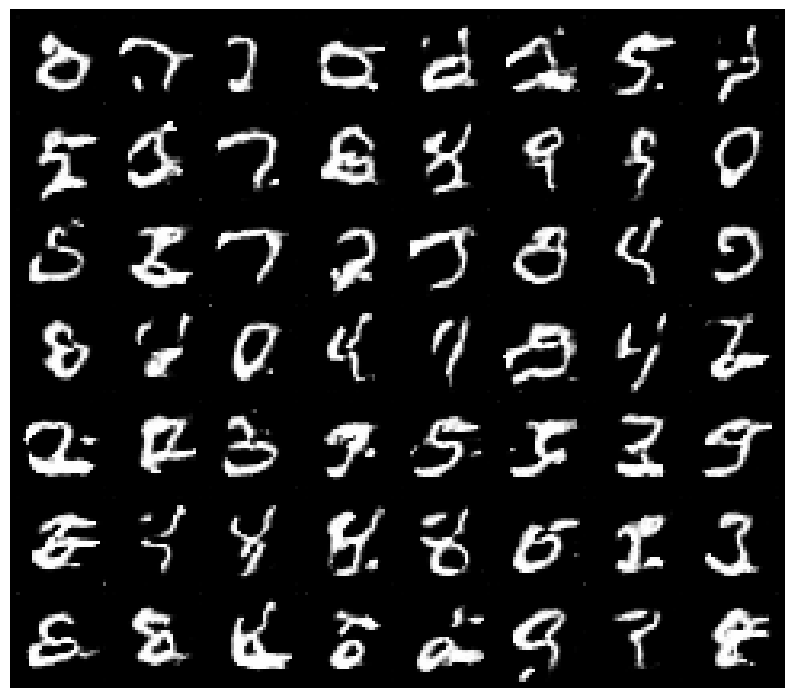

100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.52it/s, loss_D=1.01, loss_G=1.53]


Epoch [14/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [14/200] - Average D loss: 0.9319, Average G loss: 1.3536


100%|█████████████████████████████████████████████████████| 732/732 [00:46<00:00, 15.65it/s, loss_D=0.737, loss_G=1.45]


Epoch [15/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [15/200] - Average D loss: 0.8854, Average G loss: 1.4354


100%|█████████████████████████████████████████████████████| 732/732 [00:46<00:00, 15.65it/s, loss_D=0.768, loss_G=1.56]


Epoch [16/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [16/200] - Average D loss: 0.8646, Average G loss: 1.4933


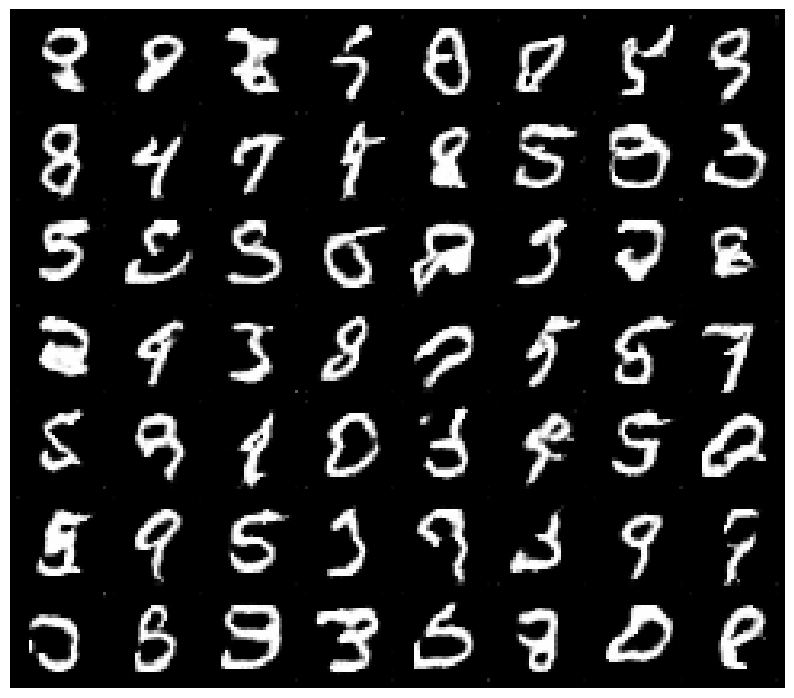

100%|█████████████████████████████████████████████████████| 732/732 [00:46<00:00, 15.70it/s, loss_D=0.657, loss_G=2.05]


Epoch [17/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [17/200] - Average D loss: 0.8262, Average G loss: 1.5728


100%|█████████████████████████████████████████████████████| 732/732 [00:46<00:00, 15.73it/s, loss_D=0.896, loss_G=1.52]


Epoch [18/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [18/200] - Average D loss: 0.8060, Average G loss: 1.6317


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.56it/s, loss_D=0.989, loss_G=1.95]

Epoch [19/200] - LR G: 0.0001024, LR D: 0.0001024
Epoch [19/200] - Average D loss: 0.7854, Average G loss: 1.6875


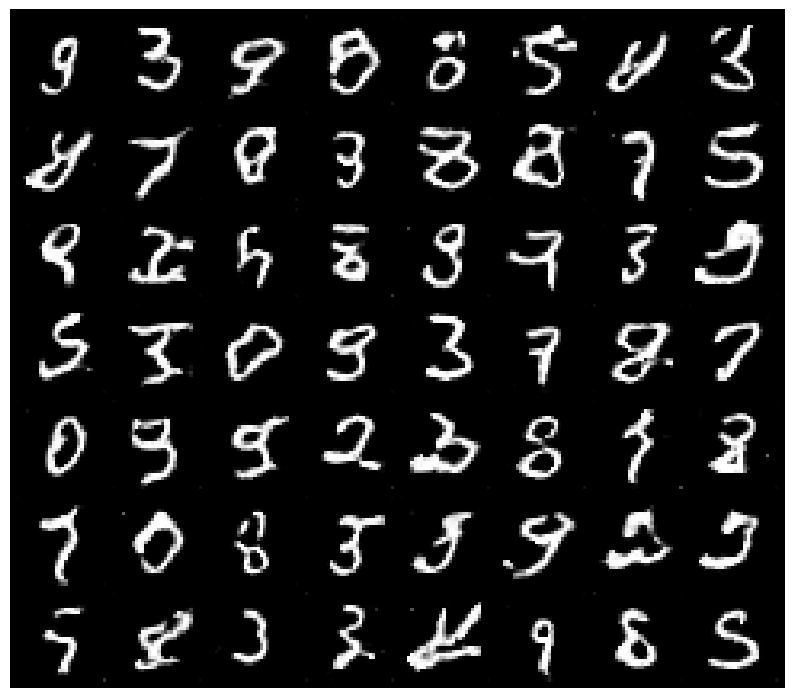

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.50it/s, loss_D=0.647, loss_G=2.04]


Epoch [20/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [20/200] - Average D loss: 0.7735, Average G loss: 1.7206


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.712, loss_G=2.08]


Epoch [21/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [21/200] - Average D loss: 0.7606, Average G loss: 1.7520


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.49it/s, loss_D=0.648, loss_G=1.81]


Epoch [22/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [22/200] - Average D loss: 0.7510, Average G loss: 1.7609


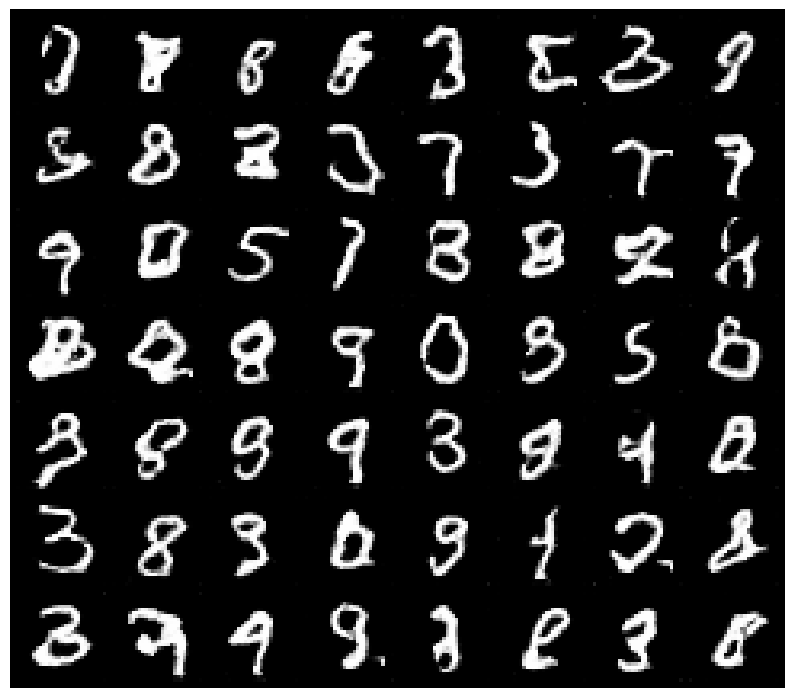

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.48it/s, loss_D=0.682, loss_G=2.03]


Epoch [23/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [23/200] - Average D loss: 0.7435, Average G loss: 1.7884


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.45it/s, loss_D=0.587, loss_G=2.09]


Epoch [24/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [24/200] - Average D loss: 0.7358, Average G loss: 1.8058


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.51it/s, loss_D=0.727, loss_G=1.79]


Epoch [25/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [25/200] - Average D loss: 0.7243, Average G loss: 1.8306


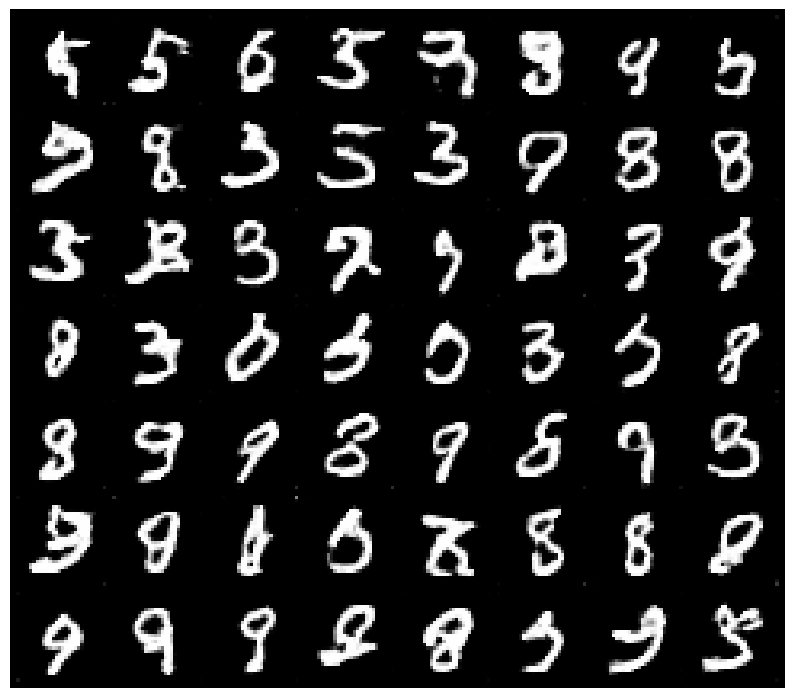

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.48it/s, loss_D=0.696, loss_G=1.92]


Epoch [26/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [26/200] - Average D loss: 0.7214, Average G loss: 1.8596


100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.50it/s, loss_D=0.74, loss_G=2.34]


Epoch [27/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [27/200] - Average D loss: 0.7091, Average G loss: 1.8789


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.52it/s, loss_D=0.636, loss_G=2.17]


Epoch [28/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [28/200] - Average D loss: 0.7046, Average G loss: 1.9029


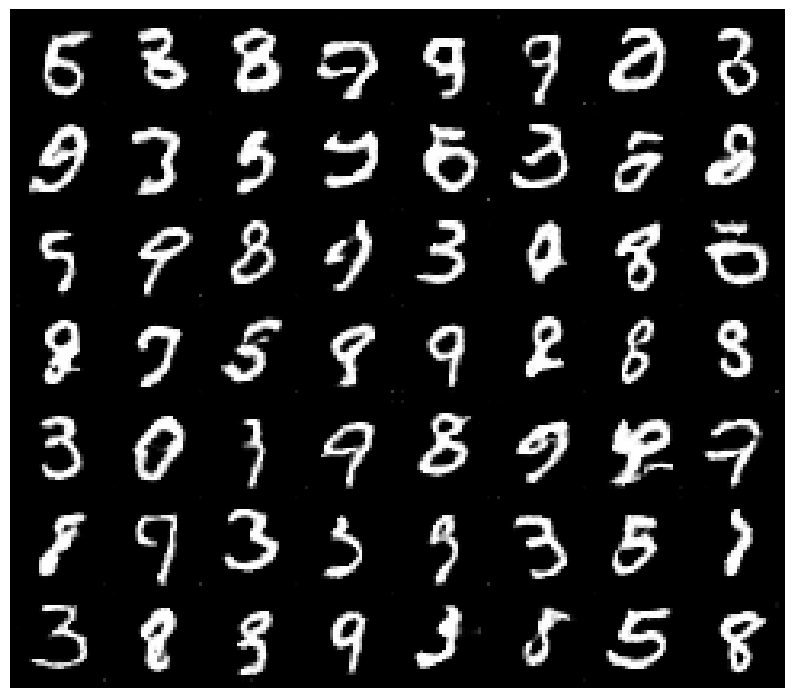

100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.48it/s, loss_D=0.695, loss_G=2.1]


Epoch [29/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [29/200] - Average D loss: 0.6964, Average G loss: 1.9191


100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.44it/s, loss_D=0.785, loss_G=1.9]


Epoch [30/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [30/200] - Average D loss: 0.6979, Average G loss: 1.9231


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.43it/s, loss_D=0.632, loss_G=1.87]

Epoch [31/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [31/200] - Average D loss: 0.6928, Average G loss: 1.9253


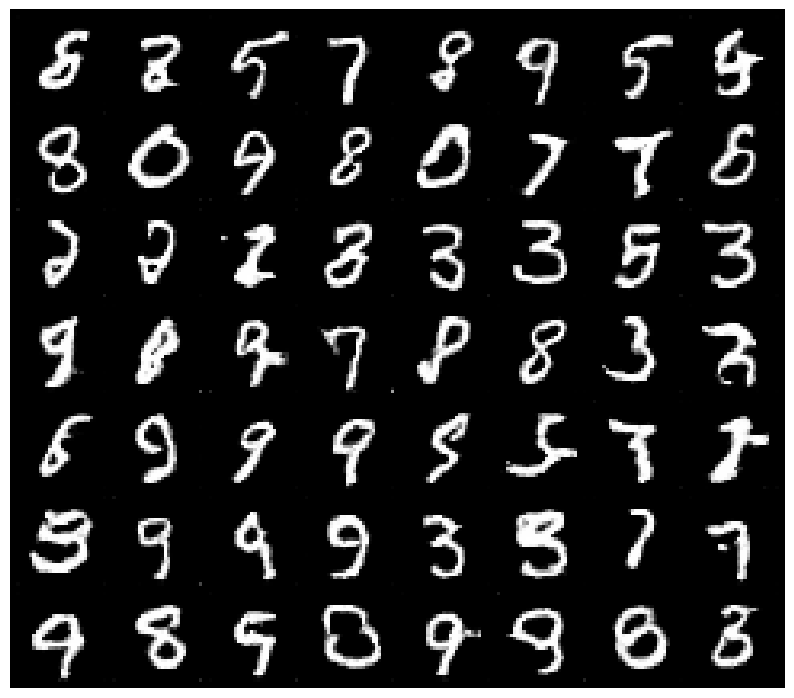

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.42it/s, loss_D=0.717, loss_G=1.48]


Epoch [32/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [32/200] - Average D loss: 0.6872, Average G loss: 1.9413


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.39it/s, loss_D=0.685, loss_G=2.22]


Epoch [33/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [33/200] - Average D loss: 0.6865, Average G loss: 1.9510


100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.43it/s, loss_D=0.71, loss_G=1.74]


Epoch [34/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [34/200] - Average D loss: 0.6813, Average G loss: 1.9617


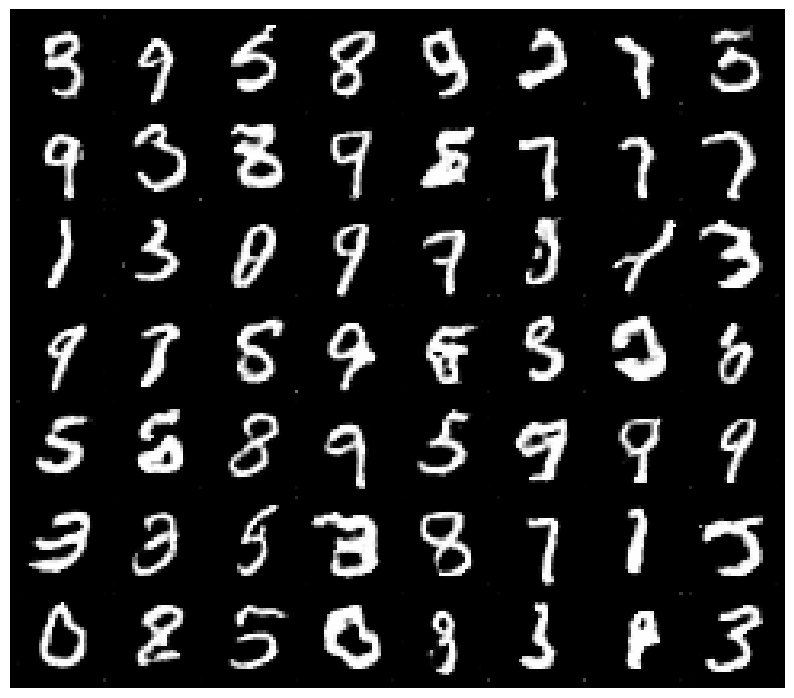

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.40it/s, loss_D=0.743, loss_G=1.69]


Epoch [35/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [35/200] - Average D loss: 0.6811, Average G loss: 1.9618


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.43it/s, loss_D=0.711, loss_G=2.01]


Epoch [36/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [36/200] - Average D loss: 0.6776, Average G loss: 1.9720


100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.41it/s, loss_D=0.73, loss_G=1.85]


Epoch [37/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [37/200] - Average D loss: 0.6795, Average G loss: 1.9692


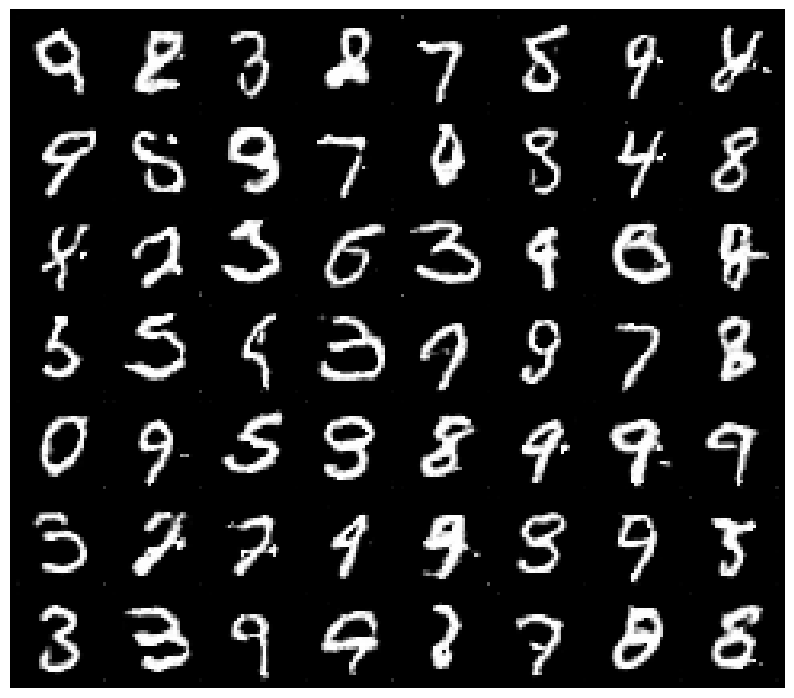

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.40it/s, loss_D=0.611, loss_G=1.73]


Epoch [38/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [38/200] - Average D loss: 0.6764, Average G loss: 1.9677


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.41it/s, loss_D=0.593, loss_G=1.72]


Epoch [39/200] - LR G: 0.0000819, LR D: 0.0000819
Epoch [39/200] - Average D loss: 0.6718, Average G loss: 1.9818


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.41it/s, loss_D=0.851, loss_G=1.43]


Epoch [40/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [40/200] - Average D loss: 0.6716, Average G loss: 1.9780


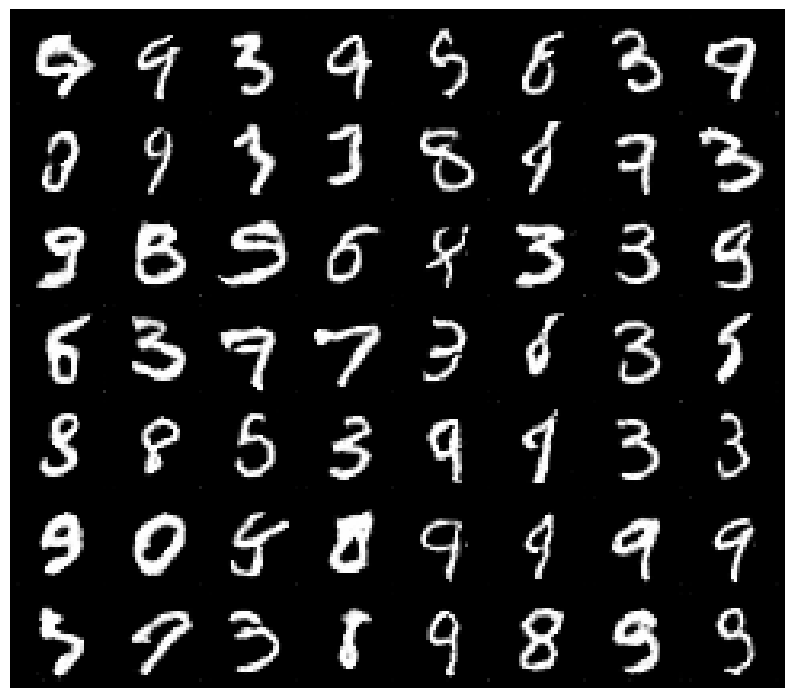

100%|████████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.43it/s, loss_D=0.662, loss_G=2]


Epoch [41/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [41/200] - Average D loss: 0.6614, Average G loss: 1.9813


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.46it/s, loss_D=0.728, loss_G=1.85]


Epoch [42/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [42/200] - Average D loss: 0.6670, Average G loss: 1.9708


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.37it/s, loss_D=0.752, loss_G=1.94]


Epoch [43/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [43/200] - Average D loss: 0.6651, Average G loss: 1.9760


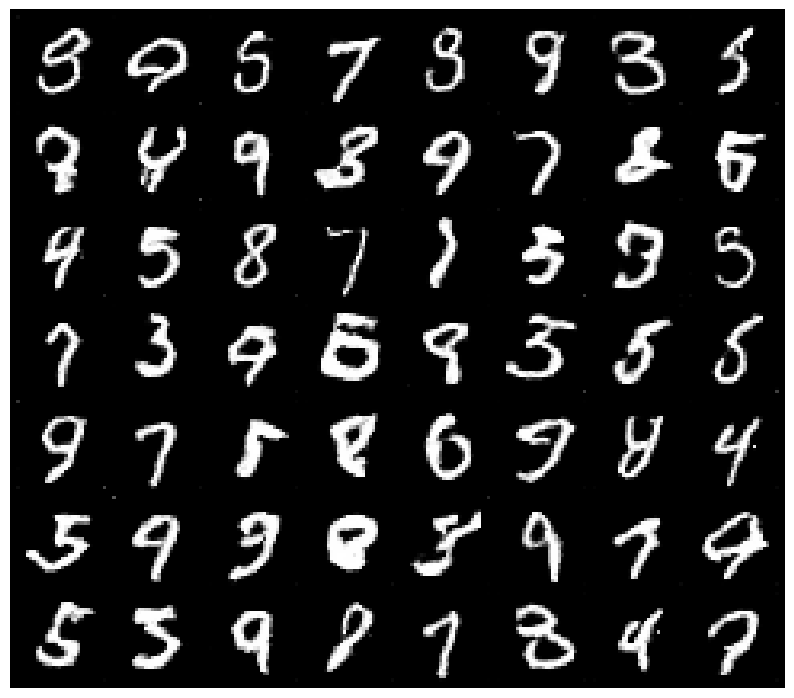

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.42it/s, loss_D=0.718, loss_G=1.96]


Epoch [44/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [44/200] - Average D loss: 0.6672, Average G loss: 1.9672


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.639, loss_G=1.73]


Epoch [45/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [45/200] - Average D loss: 0.6617, Average G loss: 1.9819


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.49it/s, loss_D=0.454, loss_G=2.36]

Epoch [46/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [46/200] - Average D loss: 0.6657, Average G loss: 1.9805


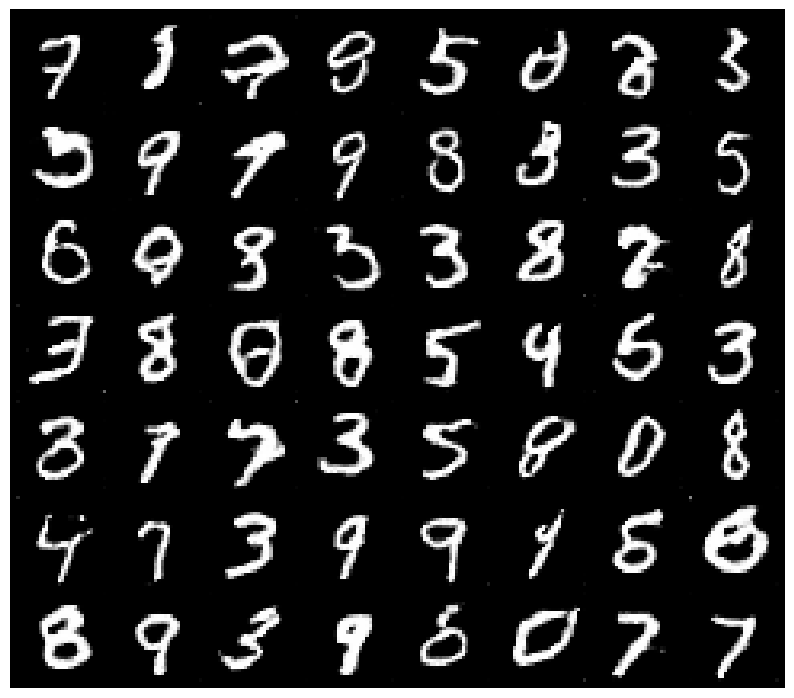

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.48it/s, loss_D=0.676, loss_G=1.48]


Epoch [47/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [47/200] - Average D loss: 0.6653, Average G loss: 1.9708


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.48it/s, loss_D=0.661, loss_G=1.97]


Epoch [48/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [48/200] - Average D loss: 0.6704, Average G loss: 1.9676


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.42it/s, loss_D=0.733, loss_G=1.87]


Epoch [49/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [49/200] - Average D loss: 0.6643, Average G loss: 1.9726


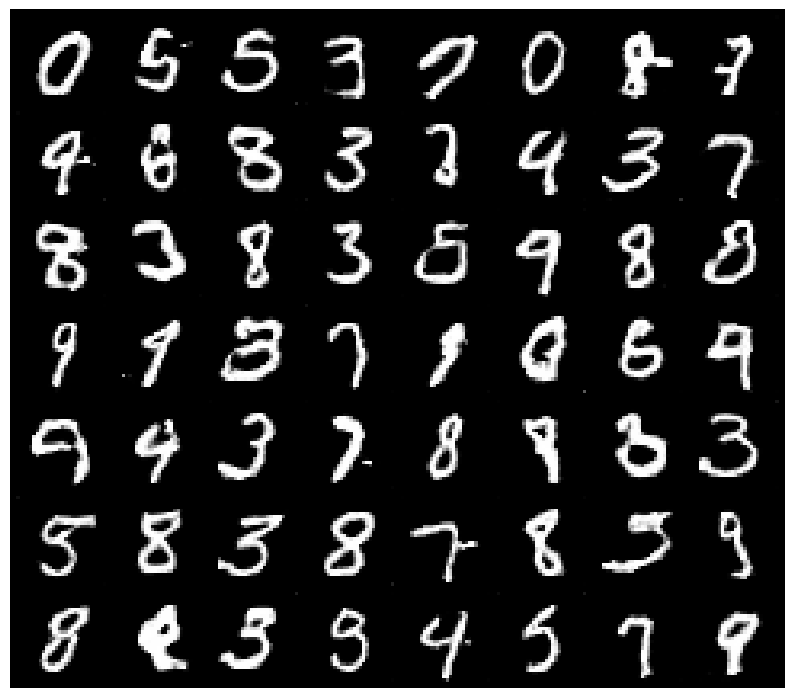

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.40it/s, loss_D=0.708, loss_G=2.32]


Epoch [50/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [50/200] - Average D loss: 0.6660, Average G loss: 1.9672


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.725, loss_G=1.72]


Epoch [51/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [51/200] - Average D loss: 0.6661, Average G loss: 1.9658


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.44it/s, loss_D=0.525, loss_G=1.95]


Epoch [52/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [52/200] - Average D loss: 0.6699, Average G loss: 1.9616


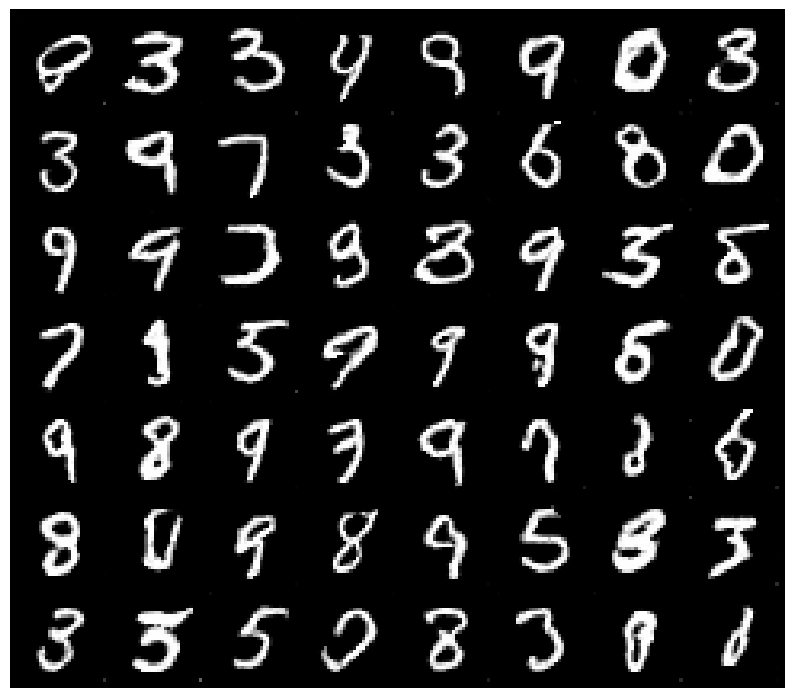

100%|█████████████████████████████████████████████████████| 732/732 [00:46<00:00, 15.66it/s, loss_D=0.713, loss_G=1.76]


Epoch [53/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [53/200] - Average D loss: 0.6619, Average G loss: 1.9728


100%|██████████████████████████████████████████████████████| 732/732 [00:46<00:00, 15.66it/s, loss_D=0.59, loss_G=1.88]


Epoch [54/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [54/200] - Average D loss: 0.6690, Average G loss: 1.9784


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.51it/s, loss_D=0.739, loss_G=1.82]


Epoch [55/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [55/200] - Average D loss: 0.6689, Average G loss: 1.9633


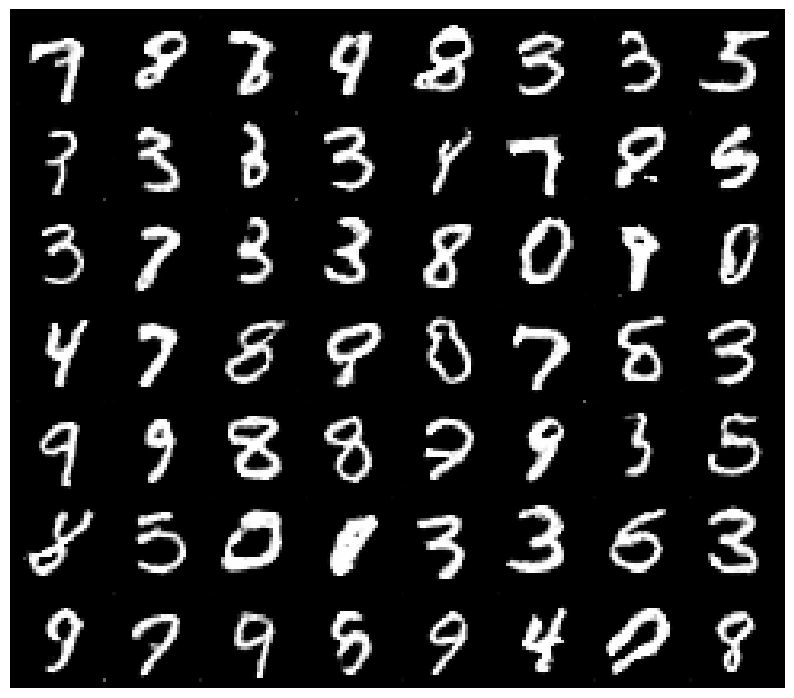

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.53it/s, loss_D=0.858, loss_G=1.67]


Epoch [56/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [56/200] - Average D loss: 0.6683, Average G loss: 1.9604


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.57it/s, loss_D=0.758, loss_G=1.82]


Epoch [57/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [57/200] - Average D loss: 0.6698, Average G loss: 1.9622


100%|█████████████████████████████████████████████████████| 732/732 [00:46<00:00, 15.61it/s, loss_D=0.703, loss_G=1.85]

Epoch [58/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [58/200] - Average D loss: 0.6765, Average G loss: 1.9362


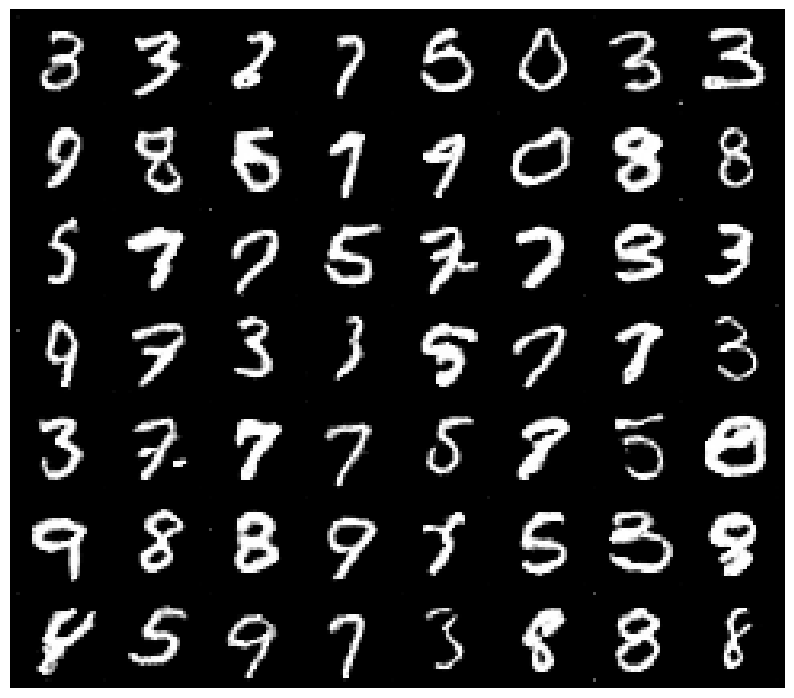

100%|███████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.42it/s, loss_D=0.7, loss_G=1.82]


Epoch [59/200] - LR G: 0.0000655, LR D: 0.0000655
Epoch [59/200] - Average D loss: 0.6704, Average G loss: 1.9518


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.45it/s, loss_D=0.746, loss_G=1.86]


Epoch [60/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [60/200] - Average D loss: 0.6740, Average G loss: 1.9330


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.692, loss_G=1.79]

Epoch [61/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [61/200] - Average D loss: 0.6702, Average G loss: 1.9293


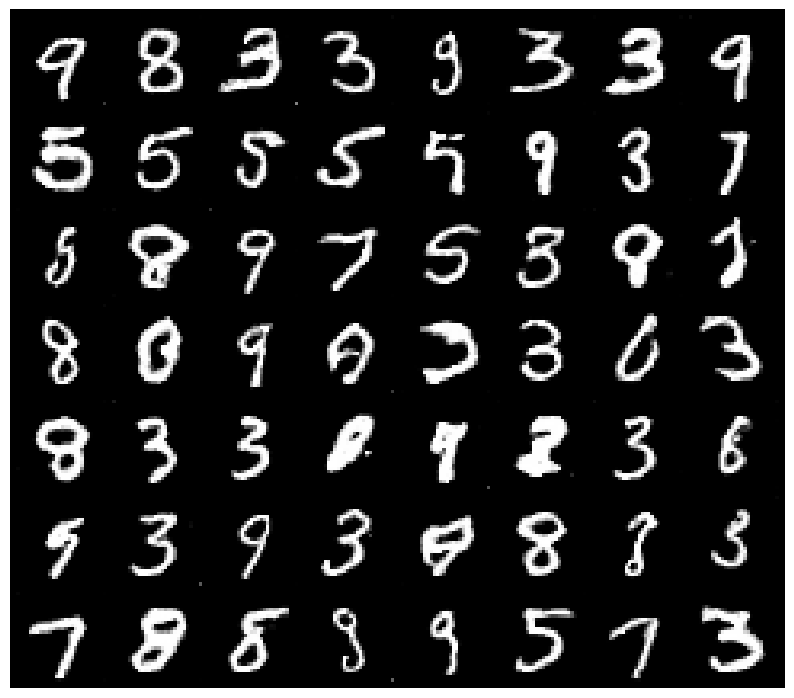

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.53it/s, loss_D=0.646, loss_G=2.19]


Epoch [62/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [62/200] - Average D loss: 0.6701, Average G loss: 1.9224


100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.45it/s, loss_D=0.65, loss_G=1.98]


Epoch [63/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [63/200] - Average D loss: 0.6717, Average G loss: 1.9264


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.45it/s, loss_D=0.629, loss_G=2.14]

Epoch [64/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [64/200] - Average D loss: 0.6731, Average G loss: 1.9271


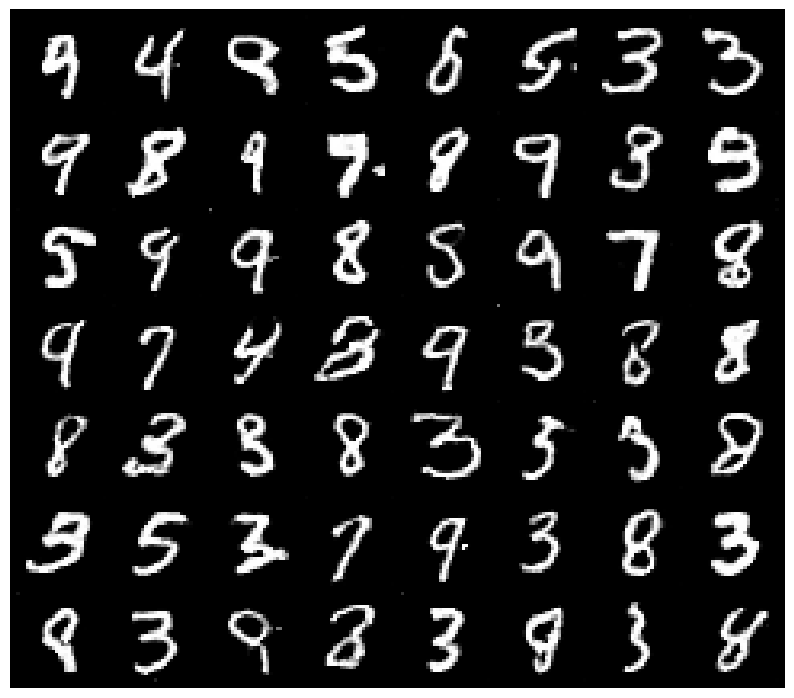

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.38it/s, loss_D=0.748, loss_G=1.92]


Epoch [65/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [65/200] - Average D loss: 0.6772, Average G loss: 1.9044


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.46it/s, loss_D=0.654, loss_G=1.76]


Epoch [66/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [66/200] - Average D loss: 0.6717, Average G loss: 1.9228


100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.49it/s, loss_D=0.54, loss_G=1.76]

Epoch [67/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [67/200] - Average D loss: 0.6764, Average G loss: 1.9082


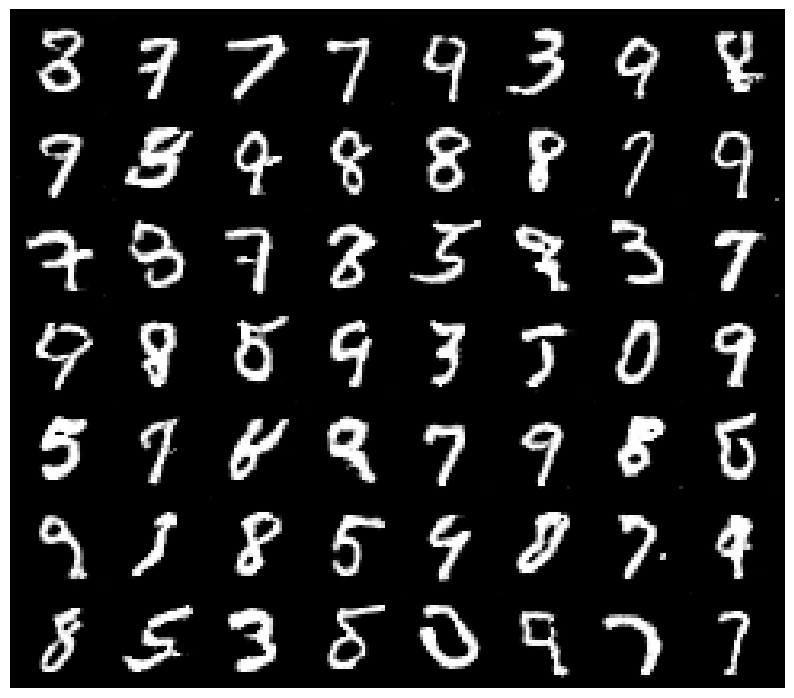

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.39it/s, loss_D=0.582, loss_G=1.89]


Epoch [68/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [68/200] - Average D loss: 0.6786, Average G loss: 1.9016


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.46it/s, loss_D=0.583, loss_G=1.76]


Epoch [69/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [69/200] - Average D loss: 0.6724, Average G loss: 1.9125


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.43it/s, loss_D=0.658, loss_G=1.88]


Epoch [70/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [70/200] - Average D loss: 0.6748, Average G loss: 1.9073


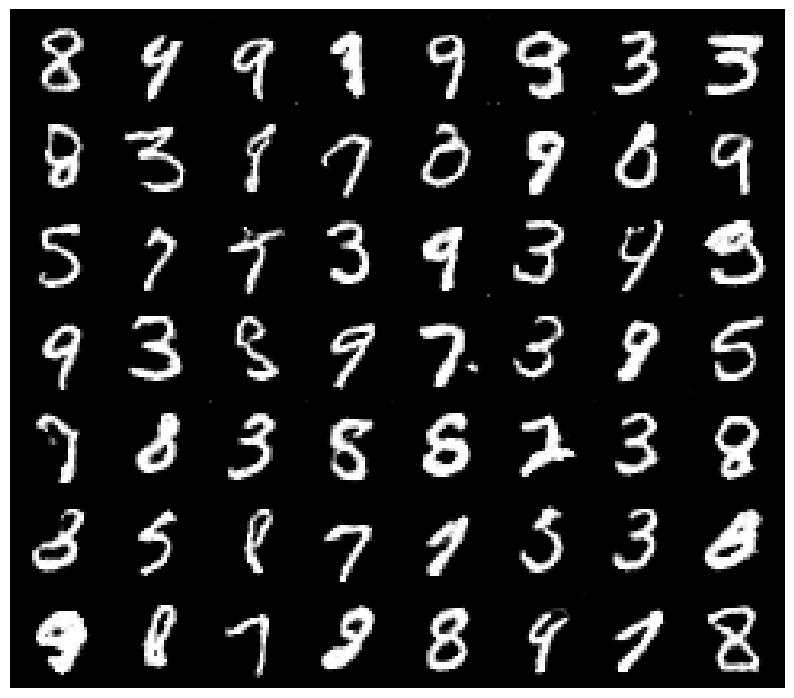

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.43it/s, loss_D=0.555, loss_G=2.21]


Epoch [71/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [71/200] - Average D loss: 0.6728, Average G loss: 1.9017


100%|████████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.50it/s, loss_D=0.7, loss_G=1.9]


Epoch [72/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [72/200] - Average D loss: 0.6782, Average G loss: 1.8940


100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.41it/s, loss_D=0.571, loss_G=1.9]


Epoch [73/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [73/200] - Average D loss: 0.6749, Average G loss: 1.9058


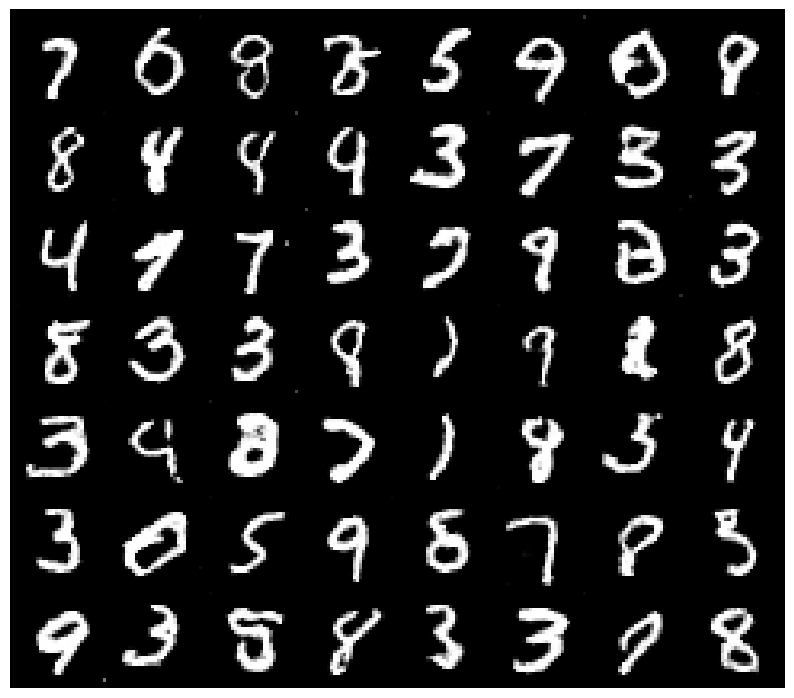

100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.46it/s, loss_D=0.75, loss_G=2.02]


Epoch [74/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [74/200] - Average D loss: 0.6677, Average G loss: 1.9125


100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.45it/s, loss_D=0.789, loss_G=2.1]


Epoch [75/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [75/200] - Average D loss: 0.6737, Average G loss: 1.9053


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.45it/s, loss_D=0.741, loss_G=2.18]


Epoch [76/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [76/200] - Average D loss: 0.6768, Average G loss: 1.9236


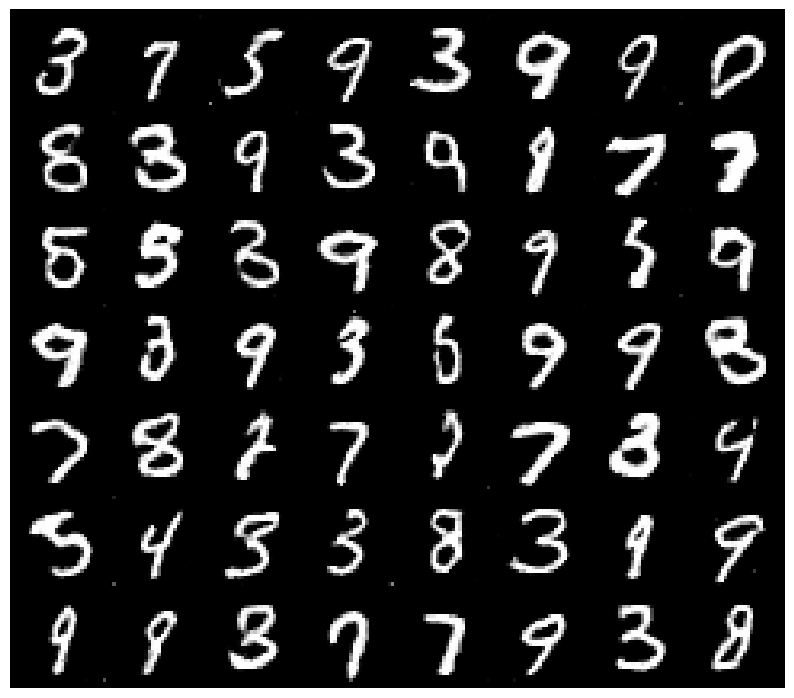

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.45it/s, loss_D=0.675, loss_G=1.83]


Epoch [77/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [77/200] - Average D loss: 0.6822, Average G loss: 1.8767


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.42it/s, loss_D=0.669, loss_G=1.63]


Epoch [78/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [78/200] - Average D loss: 0.6725, Average G loss: 1.8958


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.44it/s, loss_D=0.529, loss_G=2.01]


Epoch [79/200] - LR G: 0.0000524, LR D: 0.0000524
Epoch [79/200] - Average D loss: 0.6746, Average G loss: 1.8994


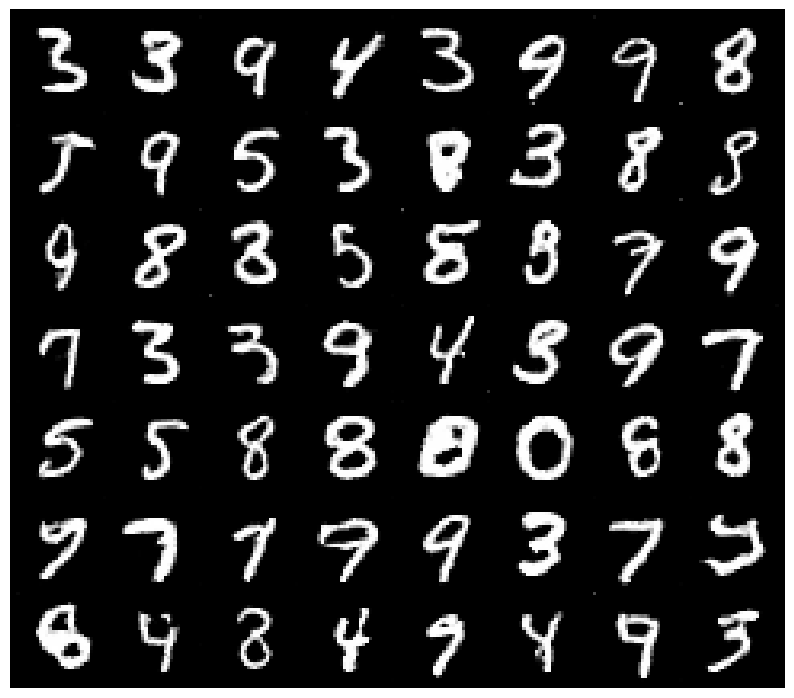

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.42it/s, loss_D=0.751, loss_G=1.81]


Epoch [80/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [80/200] - Average D loss: 0.6707, Average G loss: 1.8970


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.40it/s, loss_D=0.672, loss_G=2.08]


Epoch [81/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [81/200] - Average D loss: 0.6741, Average G loss: 1.8717


100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.53it/s, loss_D=0.81, loss_G=1.75]


Epoch [82/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [82/200] - Average D loss: 0.6750, Average G loss: 1.8723


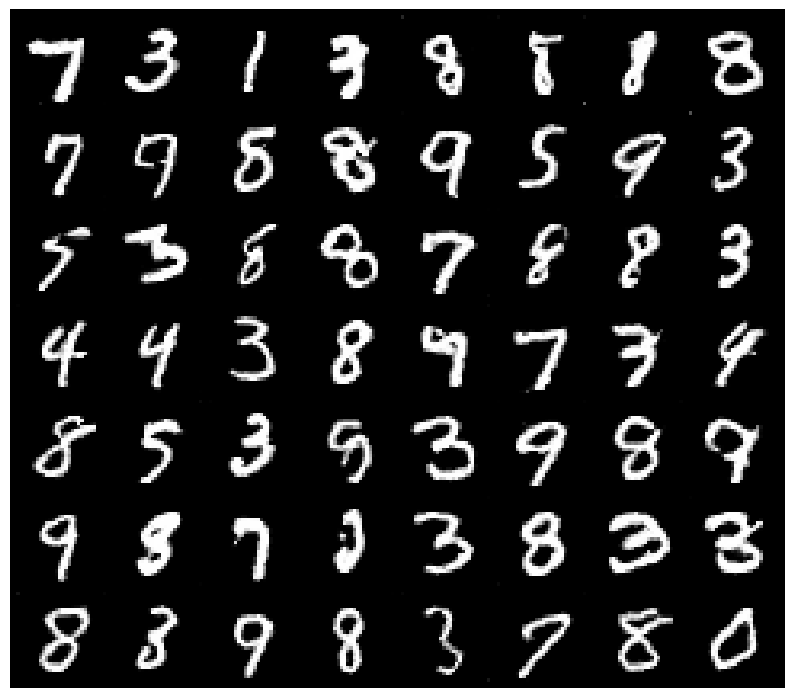

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.48it/s, loss_D=0.699, loss_G=1.82]


Epoch [83/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [83/200] - Average D loss: 0.6757, Average G loss: 1.8715


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.44it/s, loss_D=0.632, loss_G=1.83]


Epoch [84/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [84/200] - Average D loss: 0.6757, Average G loss: 1.8743


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.43it/s, loss_D=0.847, loss_G=2.05]


Epoch [85/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [85/200] - Average D loss: 0.6758, Average G loss: 1.8656


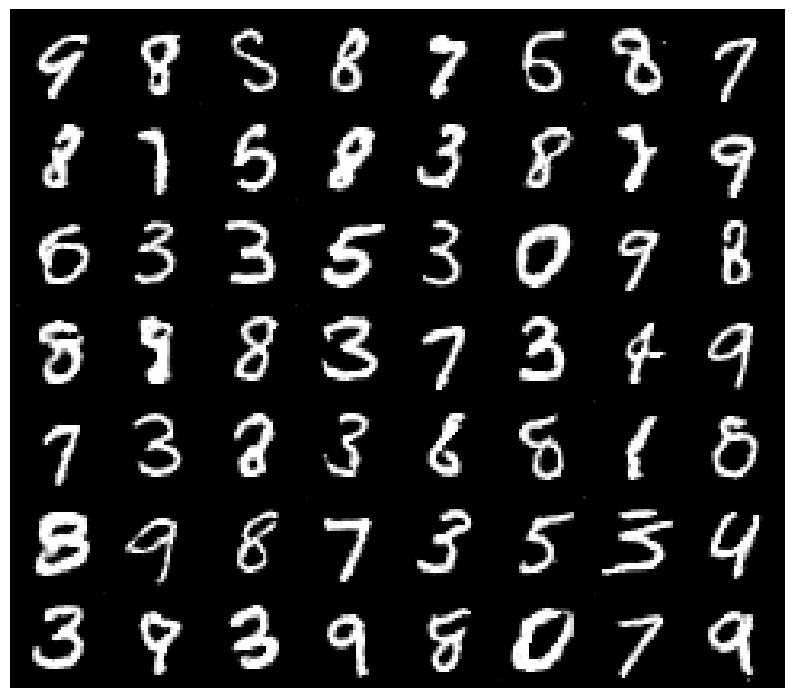

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.42it/s, loss_D=0.672, loss_G=1.93]


Epoch [86/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [86/200] - Average D loss: 0.6728, Average G loss: 1.8758


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.49it/s, loss_D=0.644, loss_G=1.73]


Epoch [87/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [87/200] - Average D loss: 0.6706, Average G loss: 1.8839


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.46it/s, loss_D=0.761, loss_G=1.79]


Epoch [88/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [88/200] - Average D loss: 0.6731, Average G loss: 1.8742


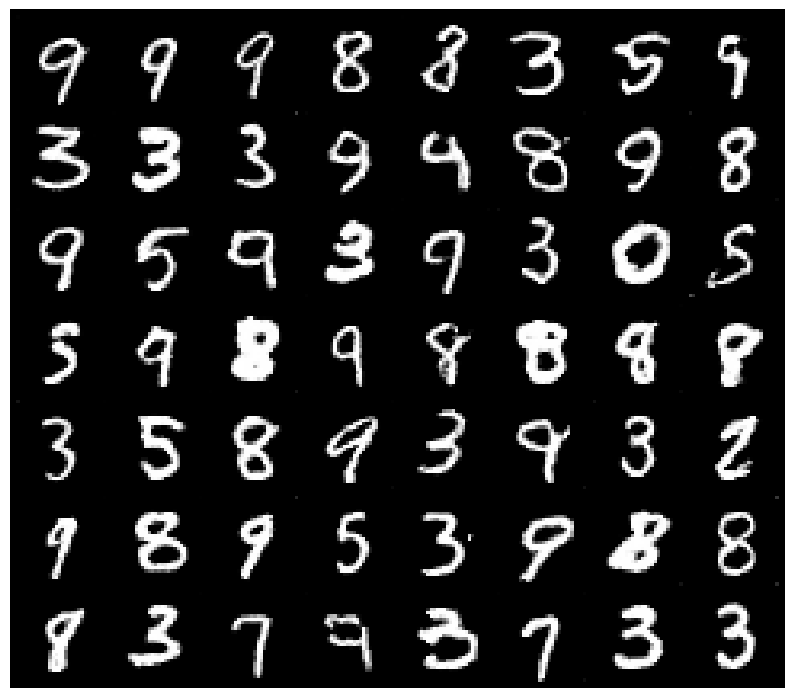

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.46it/s, loss_D=0.711, loss_G=1.99]


Epoch [89/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [89/200] - Average D loss: 0.6651, Average G loss: 1.8939


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.43it/s, loss_D=0.792, loss_G=1.79]


Epoch [90/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [90/200] - Average D loss: 0.6688, Average G loss: 1.8787


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.589, loss_G=1.96]


Epoch [91/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [91/200] - Average D loss: 0.6666, Average G loss: 1.8855


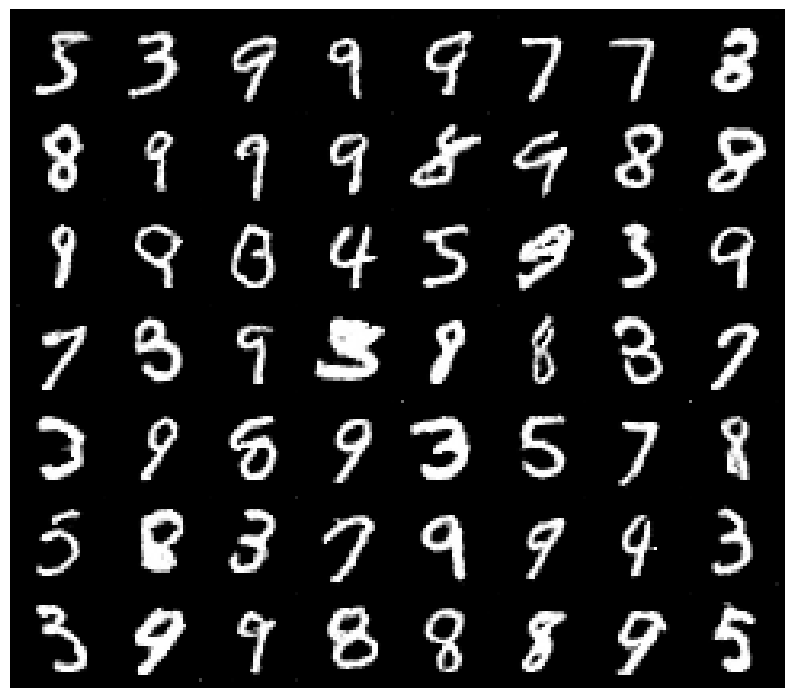

100%|███████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.44it/s, loss_D=0.8, loss_G=1.53]


Epoch [92/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [92/200] - Average D loss: 0.6661, Average G loss: 1.8827


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.44it/s, loss_D=0.653, loss_G=1.92]


Epoch [93/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [93/200] - Average D loss: 0.6655, Average G loss: 1.8958


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.51it/s, loss_D=0.682, loss_G=1.62]


Epoch [94/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [94/200] - Average D loss: 0.6668, Average G loss: 1.8866


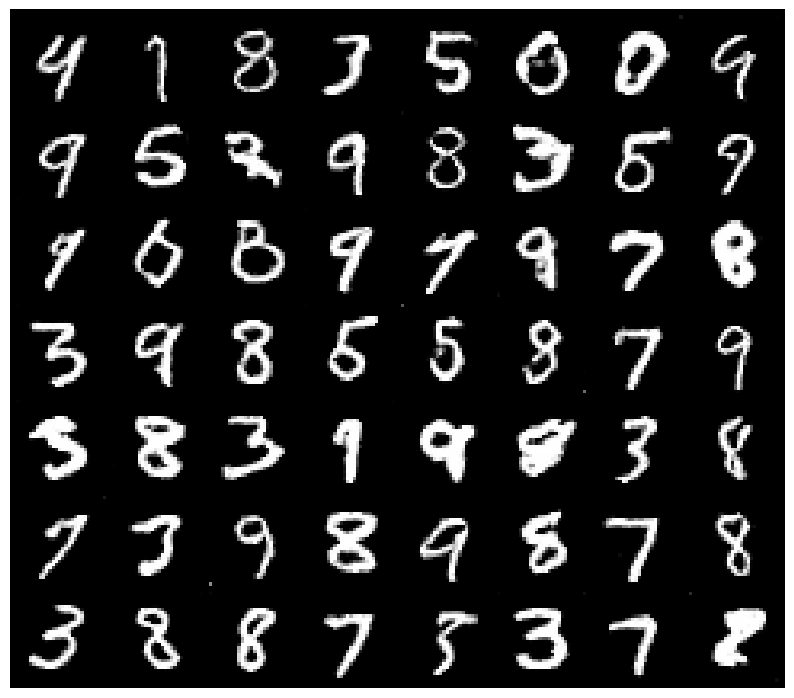

100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.44it/s, loss_D=0.567, loss_G=1.6]


Epoch [95/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [95/200] - Average D loss: 0.6599, Average G loss: 1.9061


100%|████████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.513, loss_G=2]


Epoch [96/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [96/200] - Average D loss: 0.6628, Average G loss: 1.8910


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.45it/s, loss_D=0.614, loss_G=1.94]


Epoch [97/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [97/200] - Average D loss: 0.6633, Average G loss: 1.8943


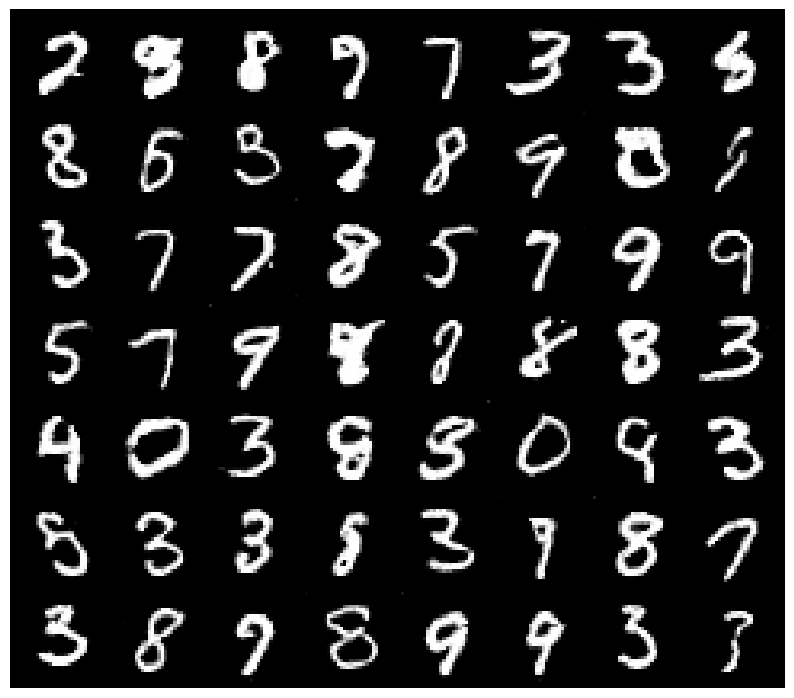

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.46it/s, loss_D=0.599, loss_G=1.82]


Epoch [98/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [98/200] - Average D loss: 0.6576, Average G loss: 1.9111


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.41it/s, loss_D=0.593, loss_G=1.81]


Epoch [99/200] - LR G: 0.0000419, LR D: 0.0000419
Epoch [99/200] - Average D loss: 0.6588, Average G loss: 1.9084


100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.46it/s, loss_D=0.625, loss_G=2.2]


Epoch [100/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [100/200] - Average D loss: 0.6575, Average G loss: 1.9139


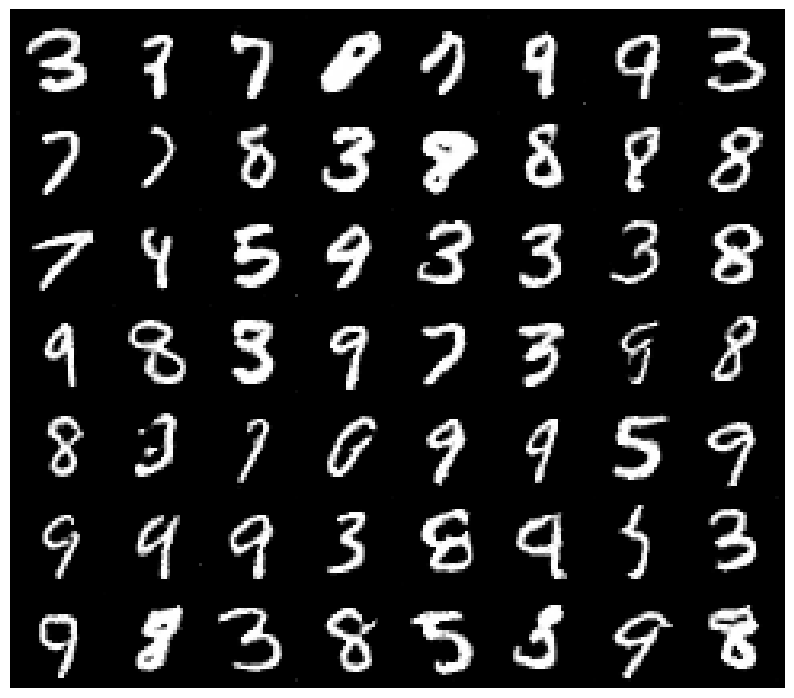

100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.46it/s, loss_D=0.72, loss_G=1.68]


Epoch [101/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [101/200] - Average D loss: 0.6596, Average G loss: 1.8997


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.808, loss_G=1.75]


Epoch [102/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [102/200] - Average D loss: 0.6628, Average G loss: 1.8906


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.46it/s, loss_D=0.767, loss_G=2.02]


Epoch [103/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [103/200] - Average D loss: 0.6637, Average G loss: 1.8933


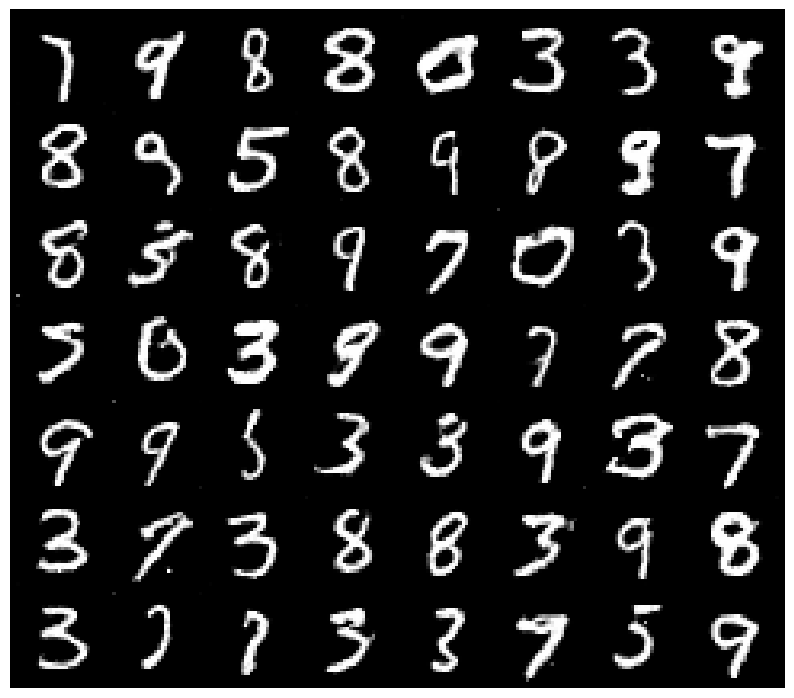

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.48it/s, loss_D=0.762, loss_G=1.86]


Epoch [104/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [104/200] - Average D loss: 0.6535, Average G loss: 1.9030


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.42it/s, loss_D=0.552, loss_G=2.14]


Epoch [105/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [105/200] - Average D loss: 0.6554, Average G loss: 1.9082


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.48it/s, loss_D=0.591, loss_G=2.29]


Epoch [106/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [106/200] - Average D loss: 0.6590, Average G loss: 1.8972


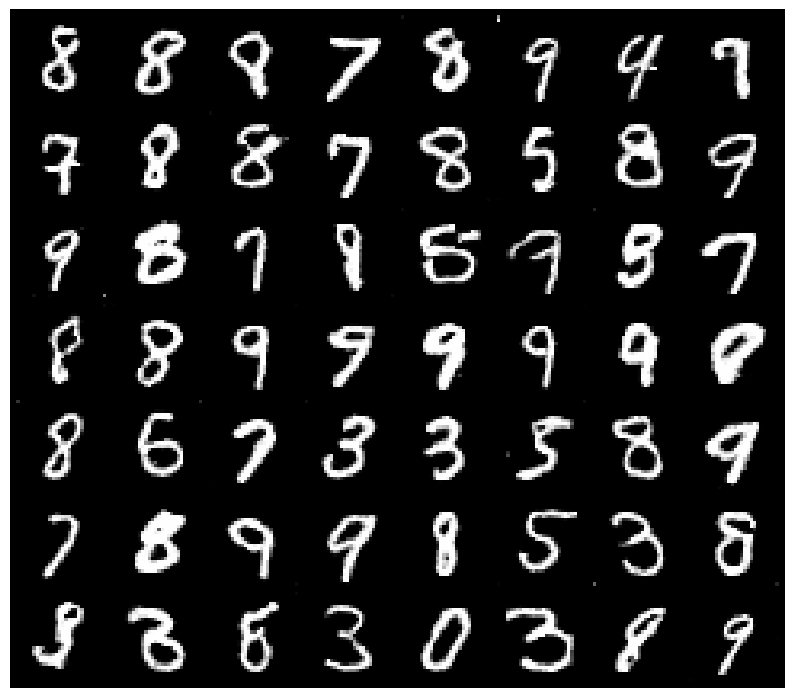

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.45it/s, loss_D=0.457, loss_G=1.89]


Epoch [107/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [107/200] - Average D loss: 0.6573, Average G loss: 1.9019


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.41it/s, loss_D=0.626, loss_G=2.05]


Epoch [108/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [108/200] - Average D loss: 0.6533, Average G loss: 1.9021


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.41it/s, loss_D=0.667, loss_G=1.62]


Epoch [109/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [109/200] - Average D loss: 0.6526, Average G loss: 1.9214


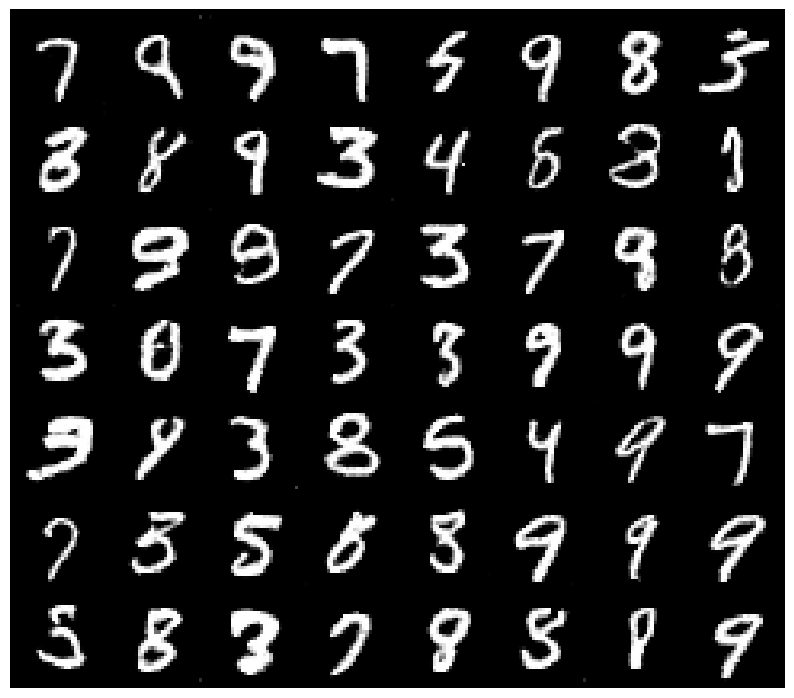

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.50it/s, loss_D=0.709, loss_G=1.93]


Epoch [110/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [110/200] - Average D loss: 0.6583, Average G loss: 1.9110


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.45it/s, loss_D=0.797, loss_G=1.61]


Epoch [111/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [111/200] - Average D loss: 0.6562, Average G loss: 1.9097


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.44it/s, loss_D=0.553, loss_G=1.97]


Epoch [112/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [112/200] - Average D loss: 0.6556, Average G loss: 1.9154


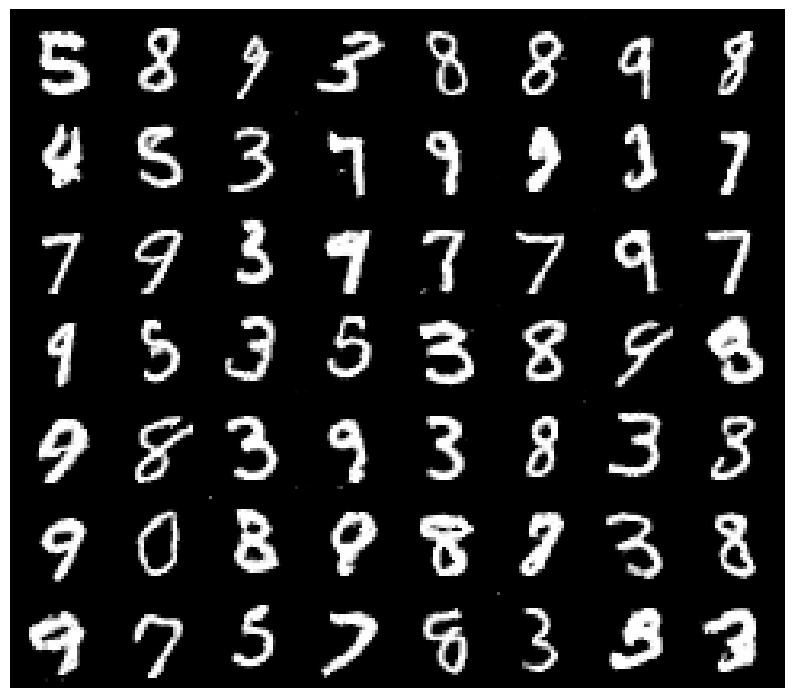

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.50it/s, loss_D=0.565, loss_G=1.89]


Epoch [113/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [113/200] - Average D loss: 0.6520, Average G loss: 1.9201


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.51it/s, loss_D=0.565, loss_G=2.04]


Epoch [114/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [114/200] - Average D loss: 0.6466, Average G loss: 1.9287


100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.44it/s, loss_D=0.579, loss_G=1.9]


Epoch [115/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [115/200] - Average D loss: 0.6465, Average G loss: 1.9272


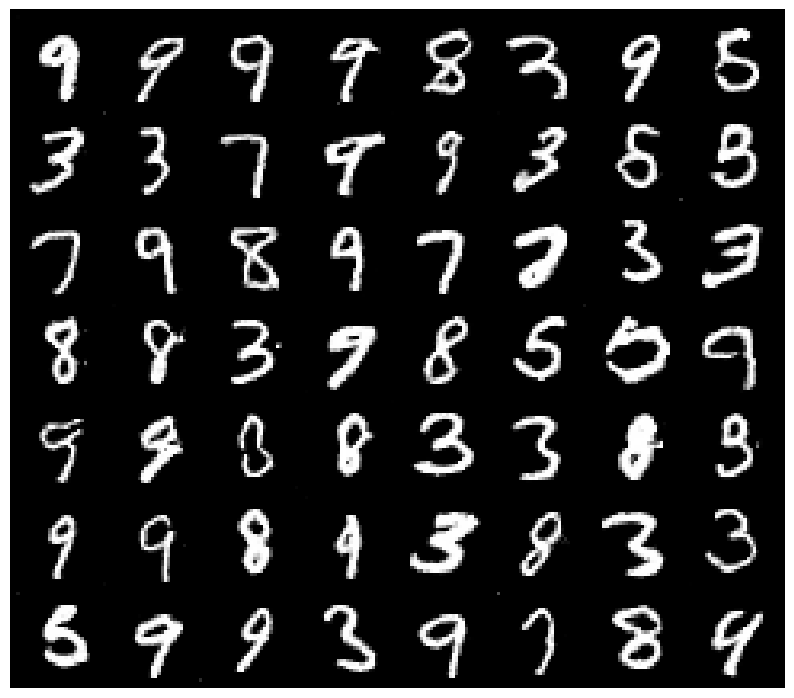

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.43it/s, loss_D=0.633, loss_G=2.15]


Epoch [116/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [116/200] - Average D loss: 0.6511, Average G loss: 1.9204


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.46it/s, loss_D=0.628, loss_G=1.77]


Epoch [117/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [117/200] - Average D loss: 0.6474, Average G loss: 1.9282


100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.68, loss_G=1.84]


Epoch [118/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [118/200] - Average D loss: 0.6470, Average G loss: 1.9366


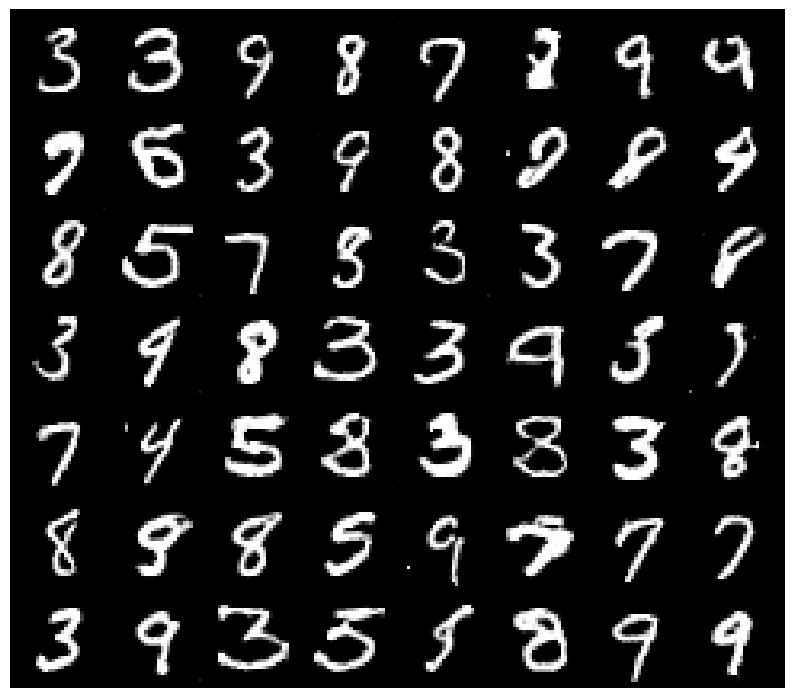

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.46it/s, loss_D=0.756, loss_G=1.76]


Epoch [119/200] - LR G: 0.0000336, LR D: 0.0000336
Epoch [119/200] - Average D loss: 0.6421, Average G loss: 1.9386


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.42it/s, loss_D=0.778, loss_G=1.98]


Epoch [120/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [120/200] - Average D loss: 0.6464, Average G loss: 1.9351


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.43it/s, loss_D=0.566, loss_G=1.86]


Epoch [121/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [121/200] - Average D loss: 0.6437, Average G loss: 1.9299


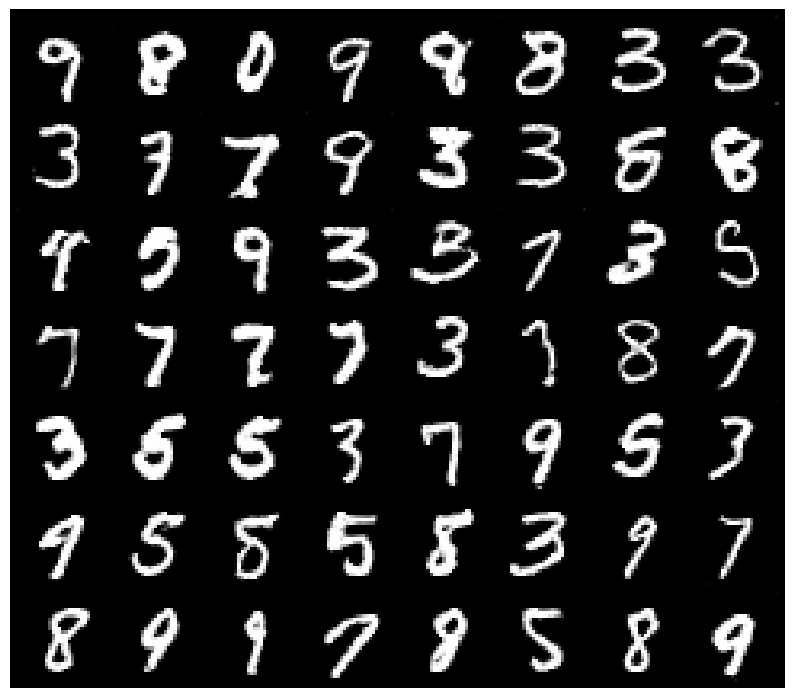

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.46it/s, loss_D=0.611, loss_G=2.04]


Epoch [122/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [122/200] - Average D loss: 0.6473, Average G loss: 1.9203


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.49it/s, loss_D=0.506, loss_G=1.96]


Epoch [123/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [123/200] - Average D loss: 0.6497, Average G loss: 1.9245


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.45it/s, loss_D=0.511, loss_G=2.16]


Epoch [124/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [124/200] - Average D loss: 0.6487, Average G loss: 1.9282


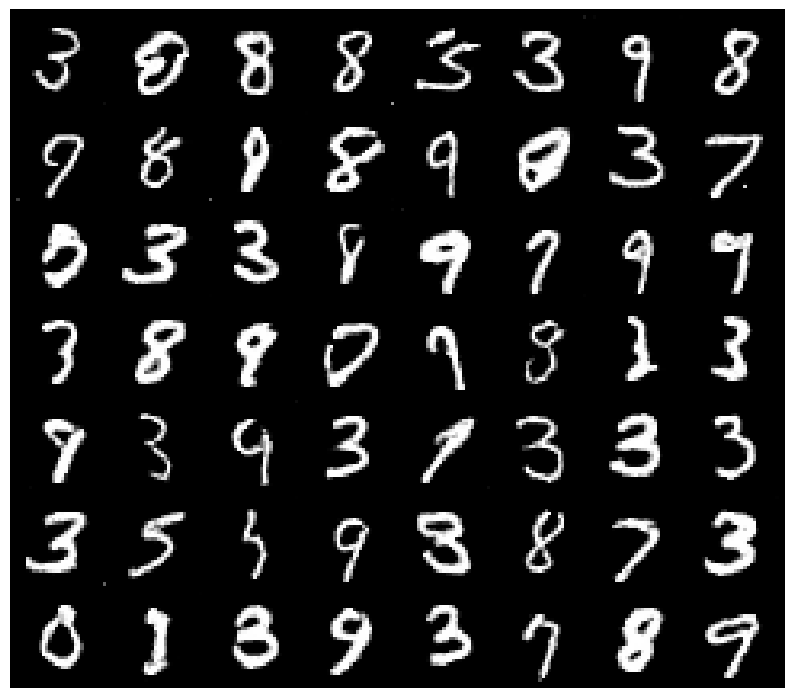

100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.45it/s, loss_D=0.68, loss_G=1.61]


Epoch [125/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [125/200] - Average D loss: 0.6422, Average G loss: 1.9274


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.49it/s, loss_D=0.839, loss_G=1.56]


Epoch [126/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [126/200] - Average D loss: 0.6413, Average G loss: 1.9372


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.49it/s, loss_D=0.691, loss_G=1.54]

Epoch [127/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [127/200] - Average D loss: 0.6456, Average G loss: 1.9361


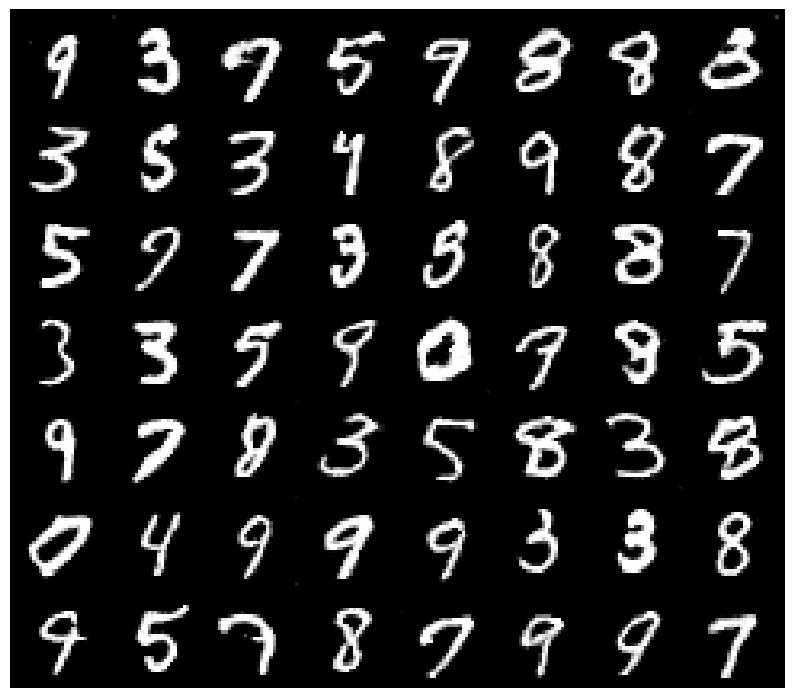

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.591, loss_G=1.99]


Epoch [128/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [128/200] - Average D loss: 0.6445, Average G loss: 1.9377


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.45it/s, loss_D=0.635, loss_G=1.83]


Epoch [129/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [129/200] - Average D loss: 0.6447, Average G loss: 1.9191


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.48it/s, loss_D=0.603, loss_G=1.83]


Epoch [130/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [130/200] - Average D loss: 0.6393, Average G loss: 1.9323


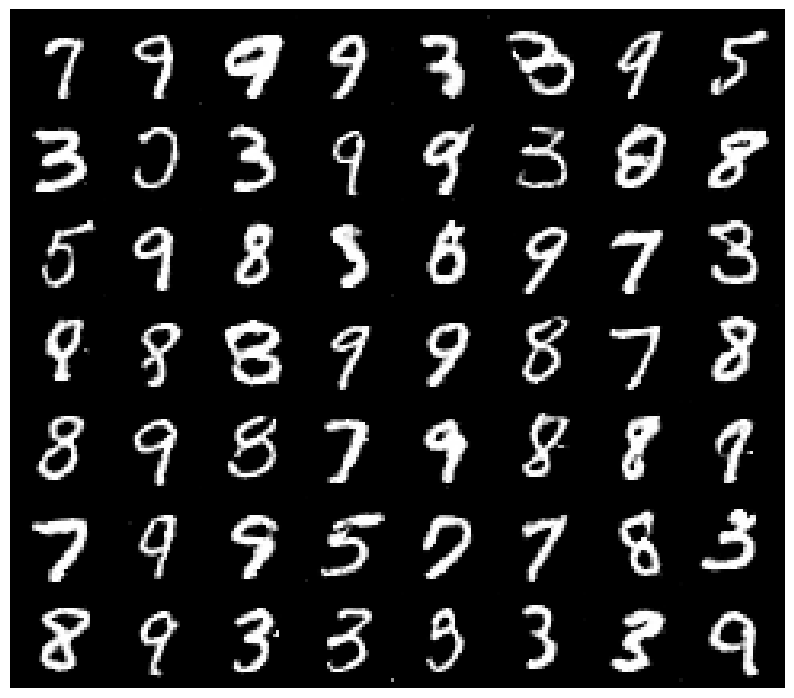

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.50it/s, loss_D=0.585, loss_G=1.94]


Epoch [131/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [131/200] - Average D loss: 0.6455, Average G loss: 1.9355


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.49it/s, loss_D=0.574, loss_G=1.78]


Epoch [132/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [132/200] - Average D loss: 0.6528, Average G loss: 1.9419


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.642, loss_G=2.22]

Epoch [133/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [133/200] - Average D loss: 0.6432, Average G loss: 1.9354


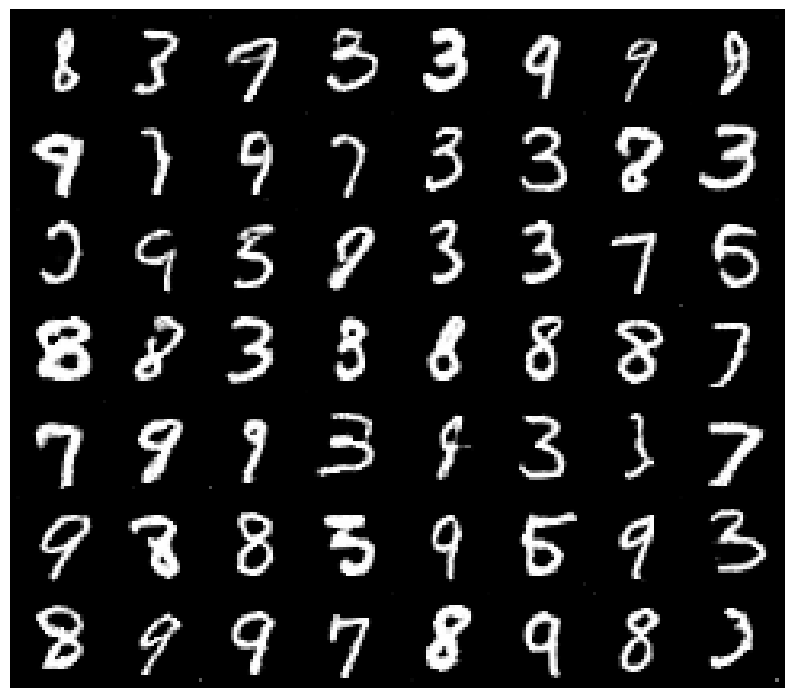

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.46it/s, loss_D=0.724, loss_G=2.13]


Epoch [134/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [134/200] - Average D loss: 0.6413, Average G loss: 1.9327


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.50it/s, loss_D=0.794, loss_G=1.77]


Epoch [135/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [135/200] - Average D loss: 0.6373, Average G loss: 1.9391


100%|████████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.48it/s, loss_D=0.521, loss_G=2]


Epoch [136/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [136/200] - Average D loss: 0.6430, Average G loss: 1.9366


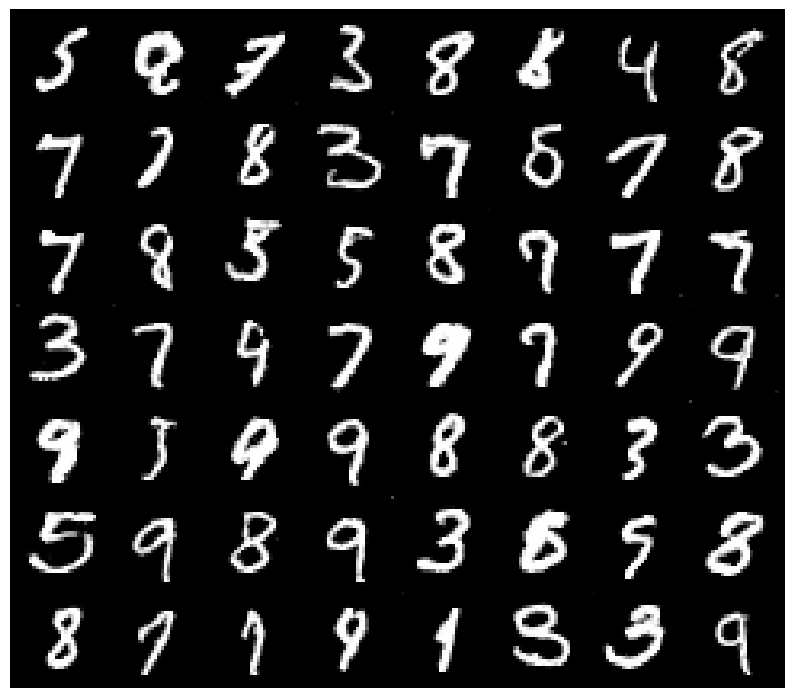

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.659, loss_G=1.95]


Epoch [137/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [137/200] - Average D loss: 0.6383, Average G loss: 1.9477


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.43it/s, loss_D=0.867, loss_G=1.85]


Epoch [138/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [138/200] - Average D loss: 0.6422, Average G loss: 1.9520


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.48it/s, loss_D=0.711, loss_G=1.57]


Epoch [139/200] - LR G: 0.0000268, LR D: 0.0000268
Epoch [139/200] - Average D loss: 0.6356, Average G loss: 1.9515


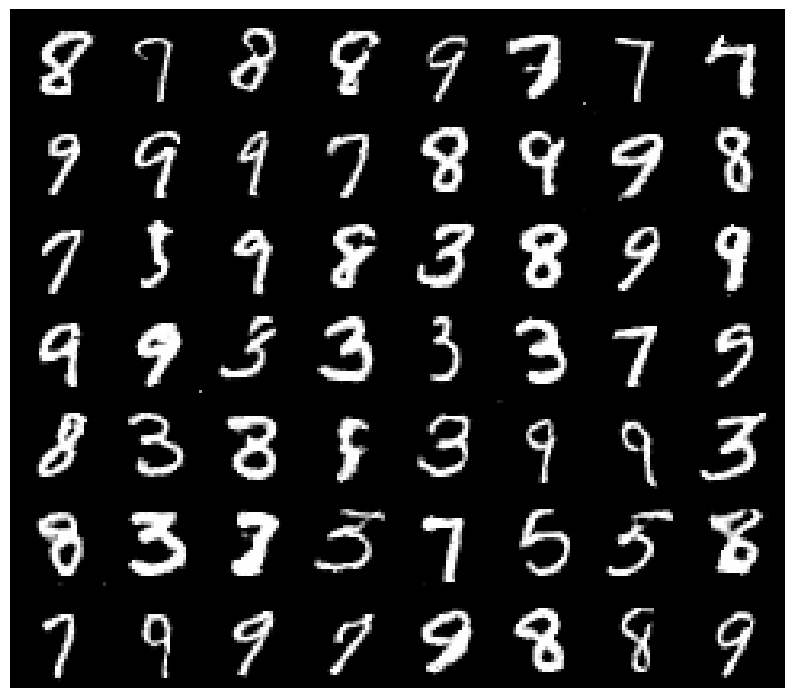

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.587, loss_G=1.97]


Epoch [140/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [140/200] - Average D loss: 0.6391, Average G loss: 1.9381


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.53it/s, loss_D=0.646, loss_G=1.91]


Epoch [141/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [141/200] - Average D loss: 0.6383, Average G loss: 1.9401


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.41it/s, loss_D=0.526, loss_G=1.74]


Epoch [142/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [142/200] - Average D loss: 0.6340, Average G loss: 1.9393


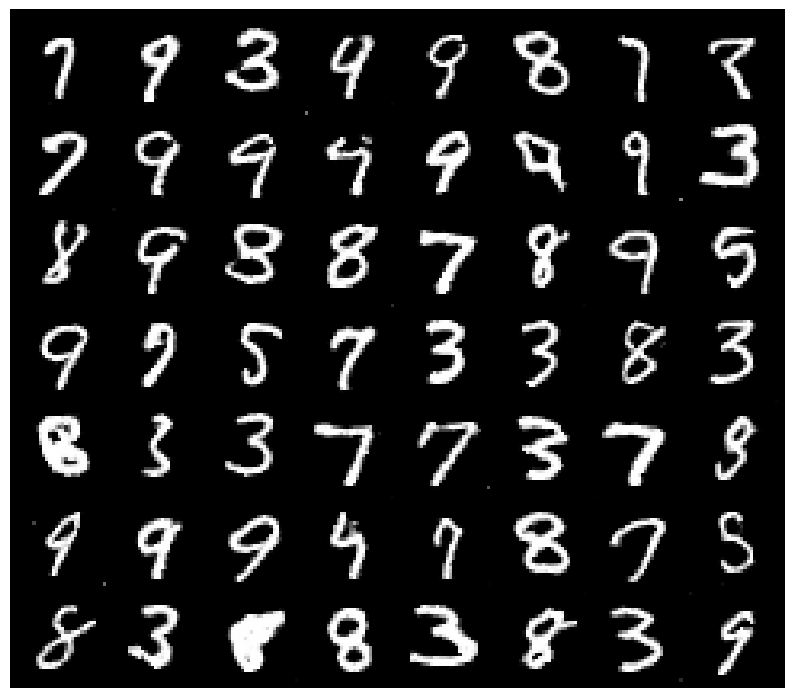

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.44it/s, loss_D=0.689, loss_G=1.75]


Epoch [143/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [143/200] - Average D loss: 0.6372, Average G loss: 1.9417


100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.42it/s, loss_D=0.65, loss_G=1.98]


Epoch [144/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [144/200] - Average D loss: 0.6411, Average G loss: 1.9291


100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.51it/s, loss_D=0.74, loss_G=1.94]


Epoch [145/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [145/200] - Average D loss: 0.6371, Average G loss: 1.9421


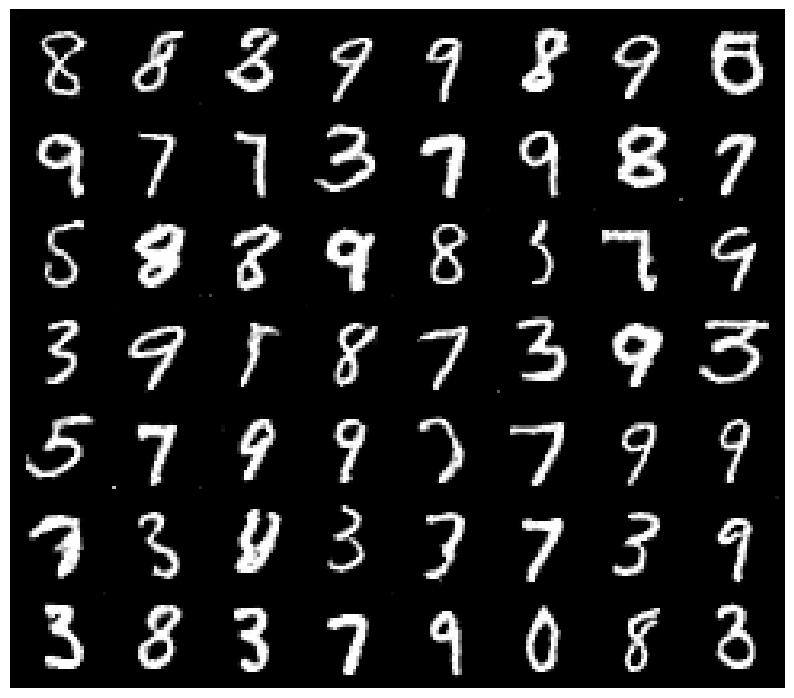

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.50it/s, loss_D=0.581, loss_G=1.73]


Epoch [146/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [146/200] - Average D loss: 0.6366, Average G loss: 1.9476


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.584, loss_G=1.94]


Epoch [147/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [147/200] - Average D loss: 0.6379, Average G loss: 1.9377


100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.46it/s, loss_D=0.557, loss_G=2.2]


Epoch [148/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [148/200] - Average D loss: 0.6333, Average G loss: 1.9515


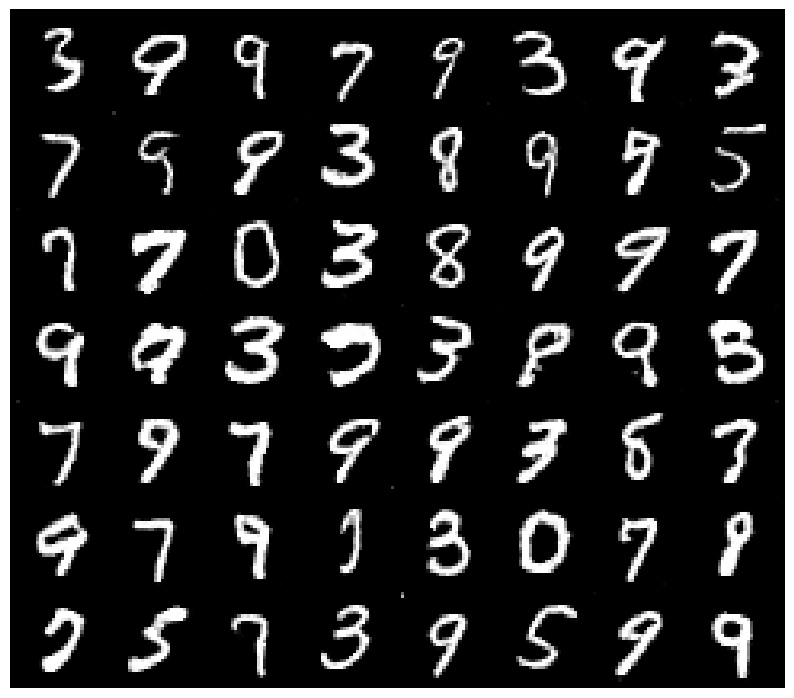

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.46it/s, loss_D=0.583, loss_G=2.27]


Epoch [149/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [149/200] - Average D loss: 0.6381, Average G loss: 1.9469


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.52it/s, loss_D=0.719, loss_G=2.01]


Epoch [150/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [150/200] - Average D loss: 0.6335, Average G loss: 1.9603


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.50it/s, loss_D=0.507, loss_G=2.16]

Epoch [151/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [151/200] - Average D loss: 0.6313, Average G loss: 1.9490


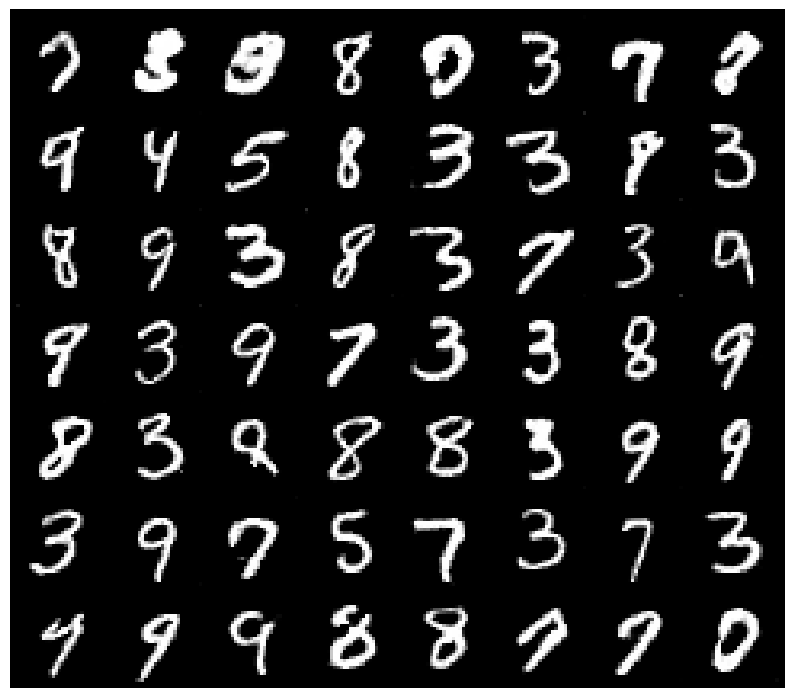

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.46it/s, loss_D=0.616, loss_G=2.06]


Epoch [152/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [152/200] - Average D loss: 0.6316, Average G loss: 1.9536


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.46it/s, loss_D=0.553, loss_G=1.91]


Epoch [153/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [153/200] - Average D loss: 0.6311, Average G loss: 1.9604


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.46it/s, loss_D=0.891, loss_G=1.75]


Epoch [154/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [154/200] - Average D loss: 0.6310, Average G loss: 1.9527


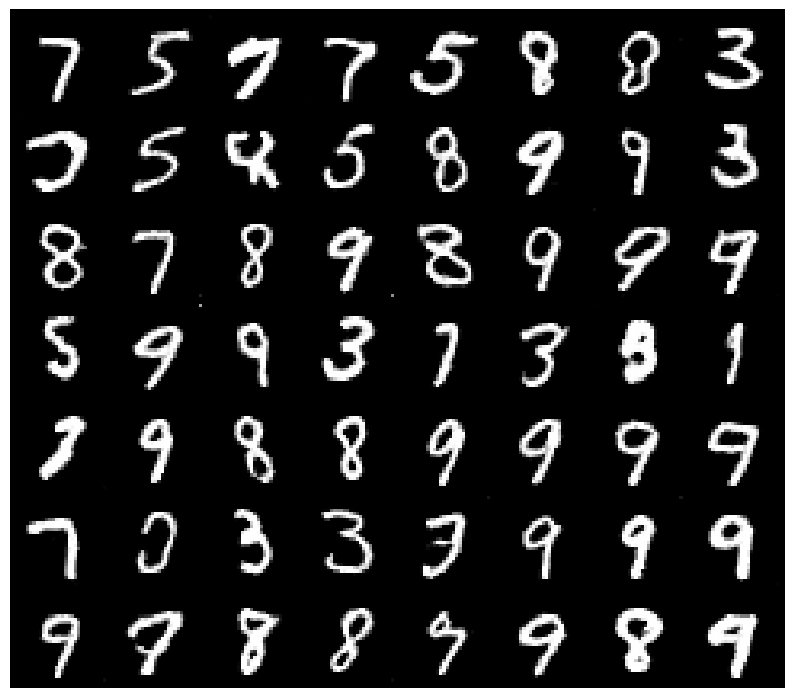

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.661, loss_G=1.95]


Epoch [155/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [155/200] - Average D loss: 0.6309, Average G loss: 1.9610


100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.712, loss_G=2.1]


Epoch [156/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [156/200] - Average D loss: 0.6333, Average G loss: 1.9444


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.45it/s, loss_D=0.548, loss_G=1.77]


Epoch [157/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [157/200] - Average D loss: 0.6261, Average G loss: 1.9672


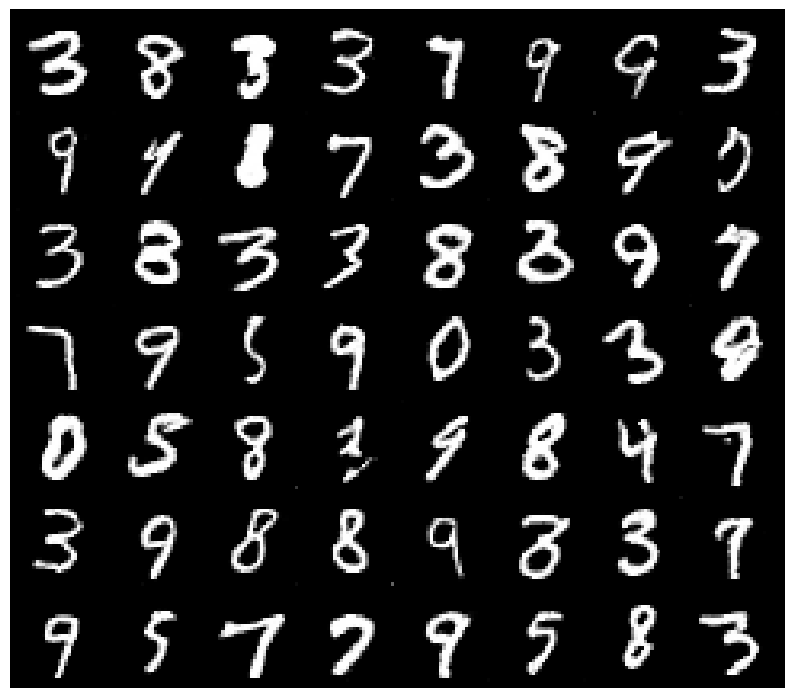

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.837, loss_G=1.74]


Epoch [158/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [158/200] - Average D loss: 0.6290, Average G loss: 1.9714


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.50it/s, loss_D=0.491, loss_G=2.17]


Epoch [159/200] - LR G: 0.0000215, LR D: 0.0000215
Epoch [159/200] - Average D loss: 0.6280, Average G loss: 1.9603


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.739, loss_G=1.75]


Epoch [160/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [160/200] - Average D loss: 0.6266, Average G loss: 1.9724


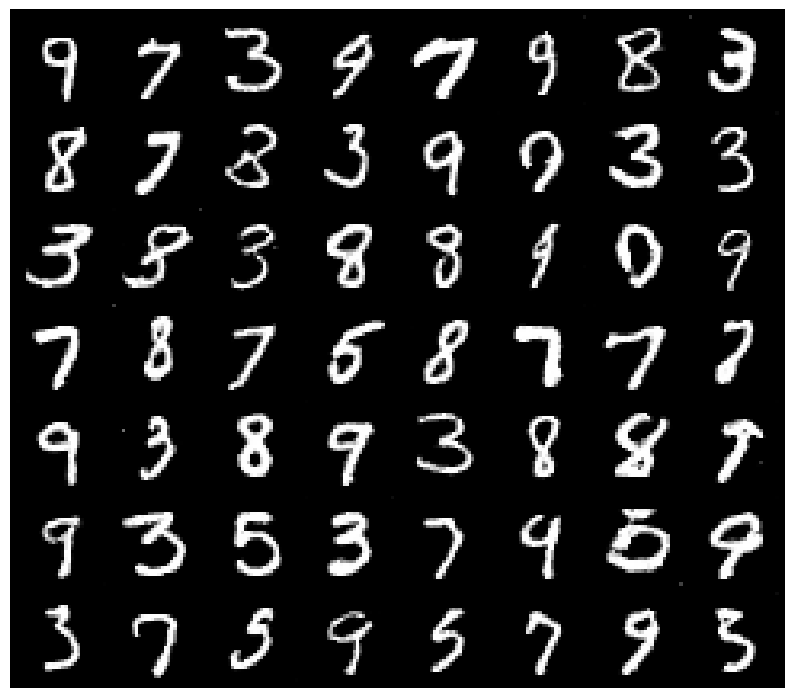

100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.54it/s, loss_D=0.568, loss_G=1.8]


Epoch [161/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [161/200] - Average D loss: 0.6282, Average G loss: 1.9677


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.48it/s, loss_D=0.713, loss_G=1.89]


Epoch [162/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [162/200] - Average D loss: 0.6294, Average G loss: 1.9597


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.43it/s, loss_D=0.601, loss_G=1.97]


Epoch [163/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [163/200] - Average D loss: 0.6294, Average G loss: 1.9547


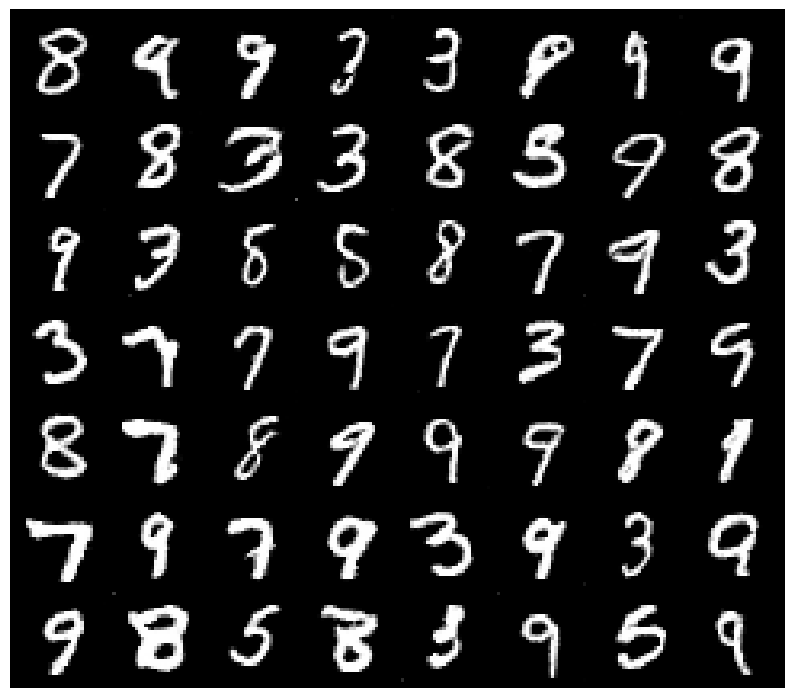

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.43it/s, loss_D=0.592, loss_G=2.53]


Epoch [164/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [164/200] - Average D loss: 0.6294, Average G loss: 1.9525


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.48it/s, loss_D=0.645, loss_G=1.72]


Epoch [165/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [165/200] - Average D loss: 0.6256, Average G loss: 1.9727


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.53it/s, loss_D=0.642, loss_G=1.86]


Epoch [166/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [166/200] - Average D loss: 0.6268, Average G loss: 1.9620


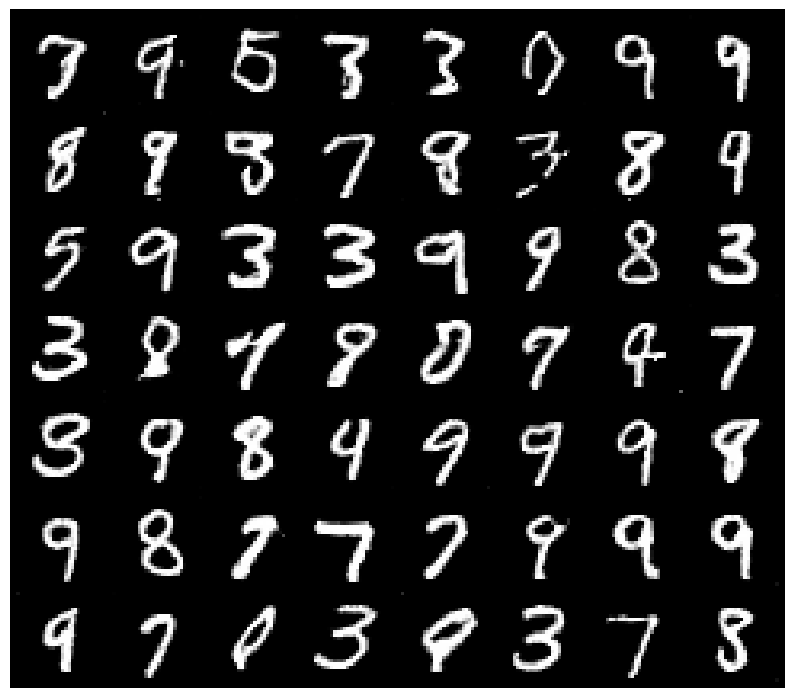

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.48it/s, loss_D=0.649, loss_G=1.86]


Epoch [167/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [167/200] - Average D loss: 0.6256, Average G loss: 1.9705


100%|████████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.48it/s, loss_D=0.663, loss_G=2]


Epoch [168/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [168/200] - Average D loss: 0.6259, Average G loss: 1.9712


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.43it/s, loss_D=0.492, loss_G=1.87]

Epoch [169/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [169/200] - Average D loss: 0.6312, Average G loss: 1.9582


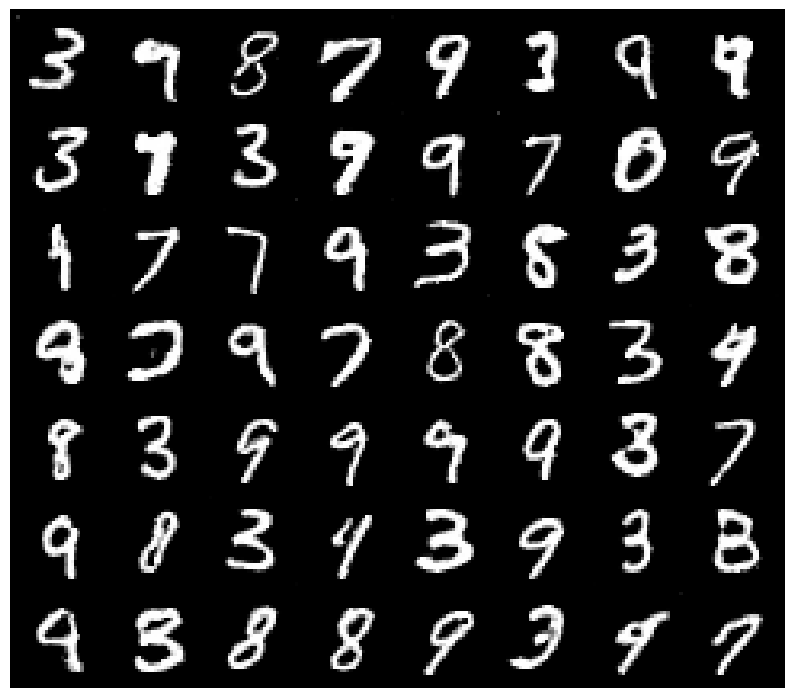

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.44it/s, loss_D=0.643, loss_G=2.04]


Epoch [170/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [170/200] - Average D loss: 0.6275, Average G loss: 1.9656


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.51it/s, loss_D=0.768, loss_G=1.89]


Epoch [171/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [171/200] - Average D loss: 0.6257, Average G loss: 1.9661


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.44it/s, loss_D=0.536, loss_G=1.88]


Epoch [172/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [172/200] - Average D loss: 0.6233, Average G loss: 1.9668


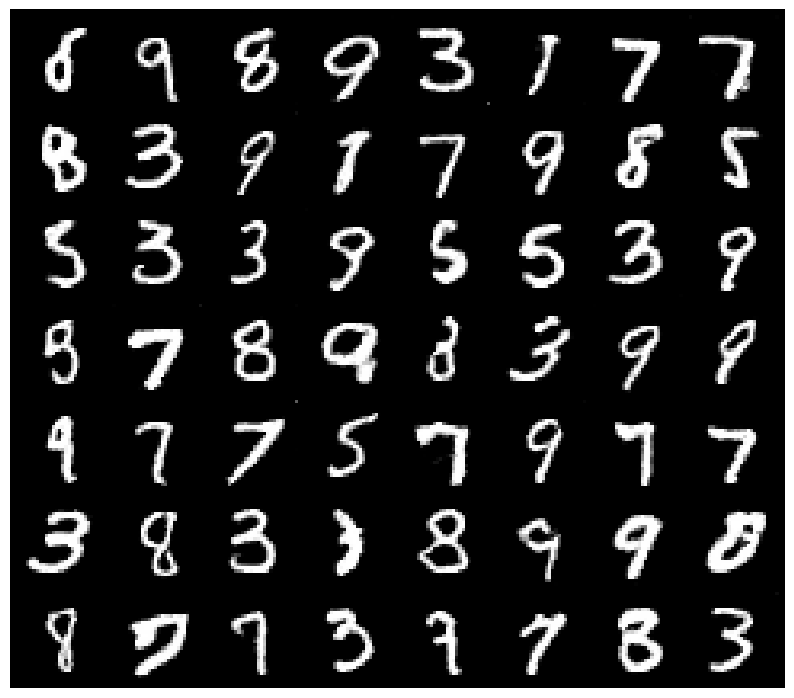

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.51it/s, loss_D=0.623, loss_G=2.05]


Epoch [173/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [173/200] - Average D loss: 0.6228, Average G loss: 1.9774


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.51it/s, loss_D=0.573, loss_G=1.92]


Epoch [174/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [174/200] - Average D loss: 0.6195, Average G loss: 1.9776


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.56it/s, loss_D=0.595, loss_G=1.94]


Epoch [175/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [175/200] - Average D loss: 0.6207, Average G loss: 1.9778


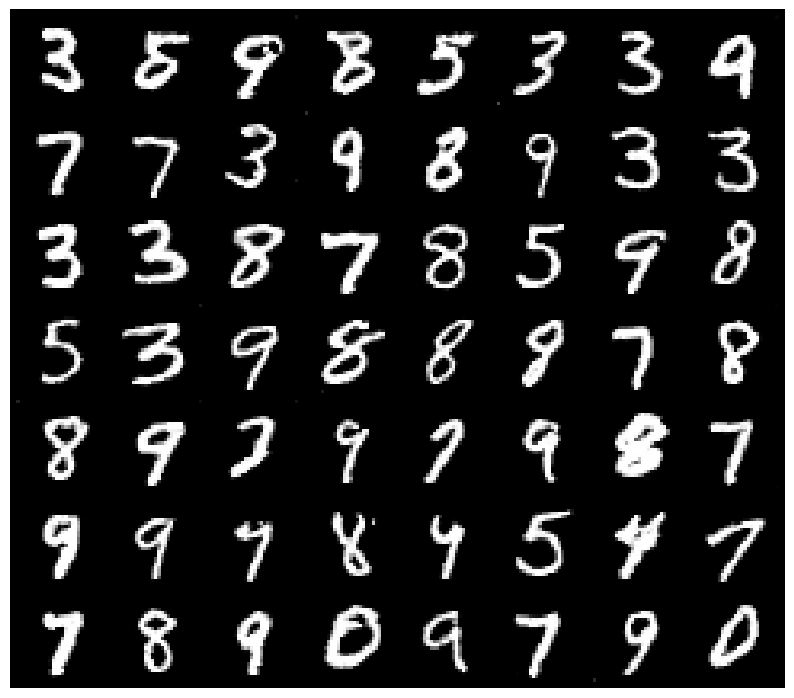

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.44it/s, loss_D=0.492, loss_G=2.06]


Epoch [176/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [176/200] - Average D loss: 0.6246, Average G loss: 1.9757


100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.49it/s, loss_D=0.49, loss_G=2.23]


Epoch [177/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [177/200] - Average D loss: 0.6222, Average G loss: 1.9781


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.48it/s, loss_D=0.706, loss_G=1.82]


Epoch [178/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [178/200] - Average D loss: 0.6207, Average G loss: 1.9893


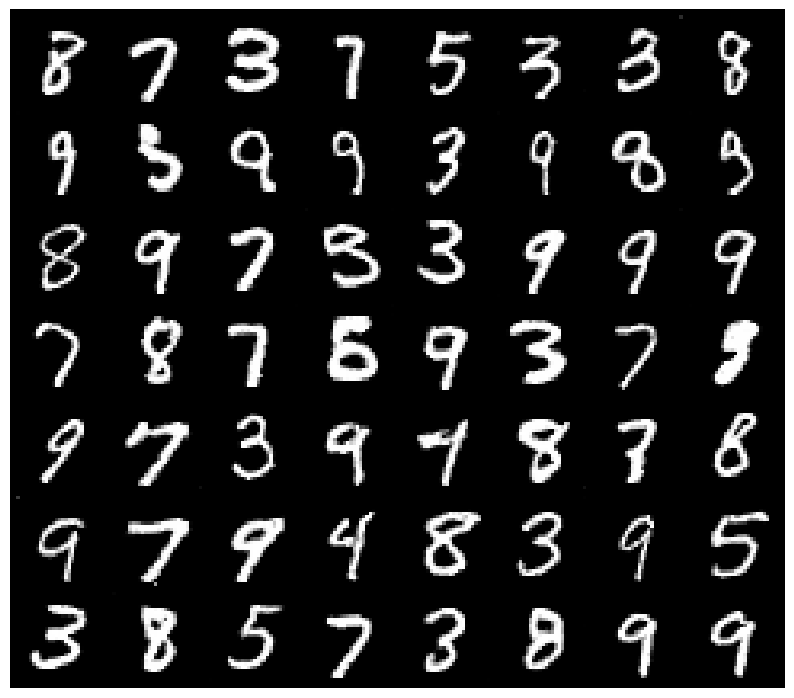

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.49it/s, loss_D=0.784, loss_G=1.95]


Epoch [179/200] - LR G: 0.0000172, LR D: 0.0000172
Epoch [179/200] - Average D loss: 0.6210, Average G loss: 1.9912


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.50it/s, loss_D=0.628, loss_G=1.96]


Epoch [180/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [180/200] - Average D loss: 0.6212, Average G loss: 1.9860


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.774, loss_G=1.69]


Epoch [181/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [181/200] - Average D loss: 0.6371, Average G loss: 1.9842


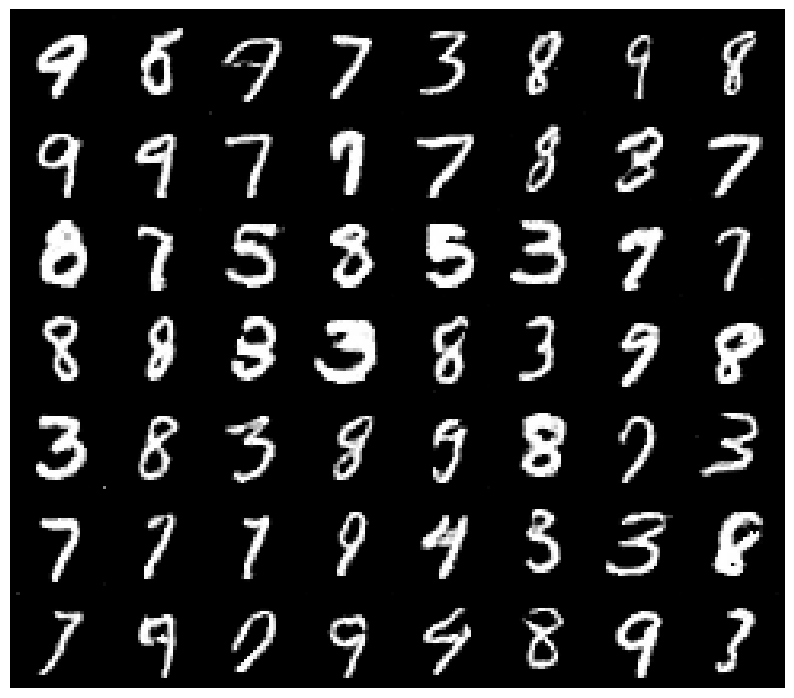

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.591, loss_G=1.81]


Epoch [182/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [182/200] - Average D loss: 0.6209, Average G loss: 1.9828


100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.50it/s, loss_D=0.786, loss_G=1.9]


Epoch [183/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [183/200] - Average D loss: 0.6194, Average G loss: 1.9672


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.51it/s, loss_D=0.544, loss_G=2.21]


Epoch [184/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [184/200] - Average D loss: 0.6224, Average G loss: 1.9765


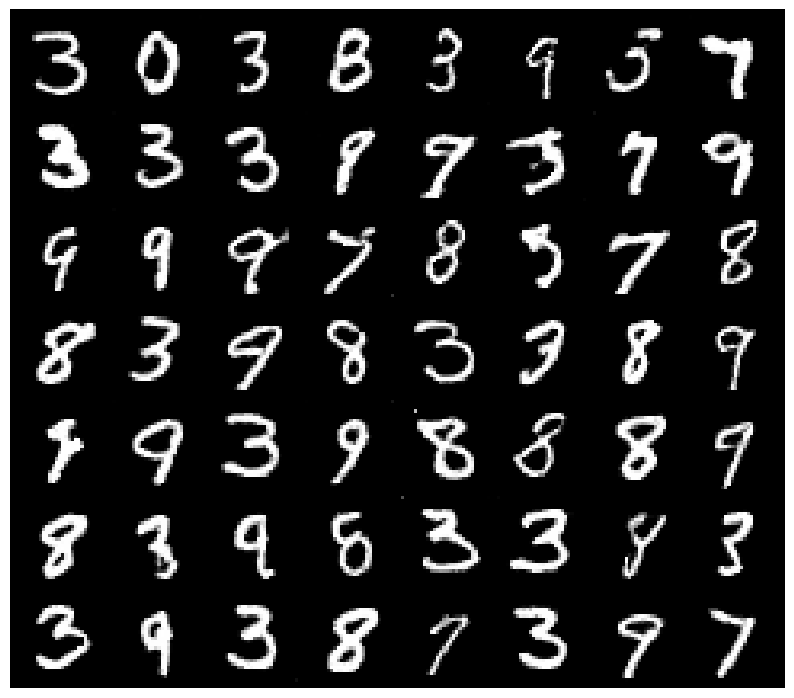

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.45it/s, loss_D=0.596, loss_G=1.95]


Epoch [185/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [185/200] - Average D loss: 0.6213, Average G loss: 1.9761


100%|██████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.64, loss_G=1.84]


Epoch [186/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [186/200] - Average D loss: 0.6205, Average G loss: 1.9726


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.42it/s, loss_D=0.544, loss_G=1.74]


Epoch [187/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [187/200] - Average D loss: 0.6216, Average G loss: 1.9701


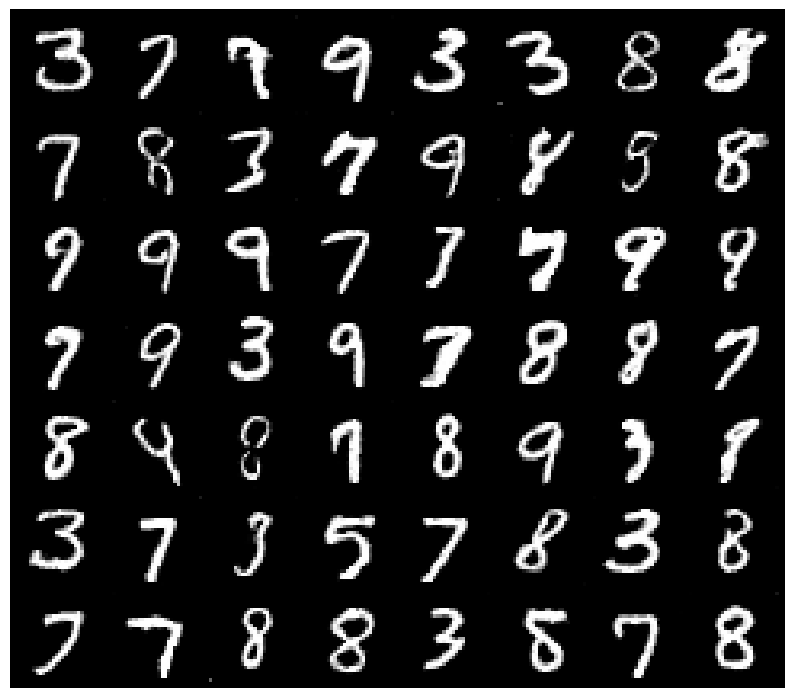

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.52it/s, loss_D=0.678, loss_G=2.01]


Epoch [188/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [188/200] - Average D loss: 0.6204, Average G loss: 1.9856


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.46it/s, loss_D=0.528, loss_G=2.01]


Epoch [189/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [189/200] - Average D loss: 0.6202, Average G loss: 1.9707


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.43it/s, loss_D=0.879, loss_G=1.94]


Epoch [190/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [190/200] - Average D loss: 0.6210, Average G loss: 1.9821


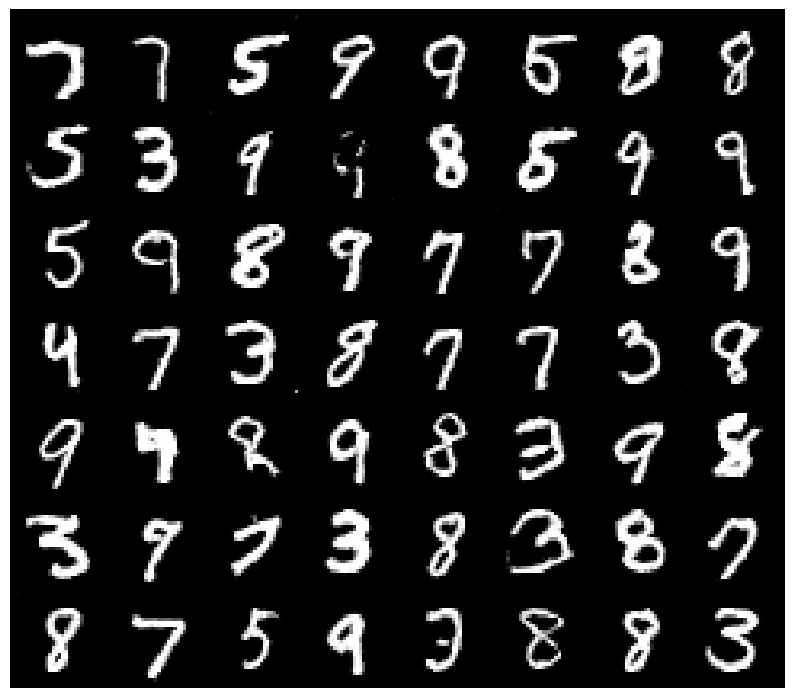

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.43it/s, loss_D=0.657, loss_G=1.76]


Epoch [191/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [191/200] - Average D loss: 0.6193, Average G loss: 1.9805


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.592, loss_G=1.93]


Epoch [192/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [192/200] - Average D loss: 0.6179, Average G loss: 1.9877


100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.49it/s, loss_D=0.566, loss_G=1.76]


Epoch [193/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [193/200] - Average D loss: 0.6220, Average G loss: 1.9713


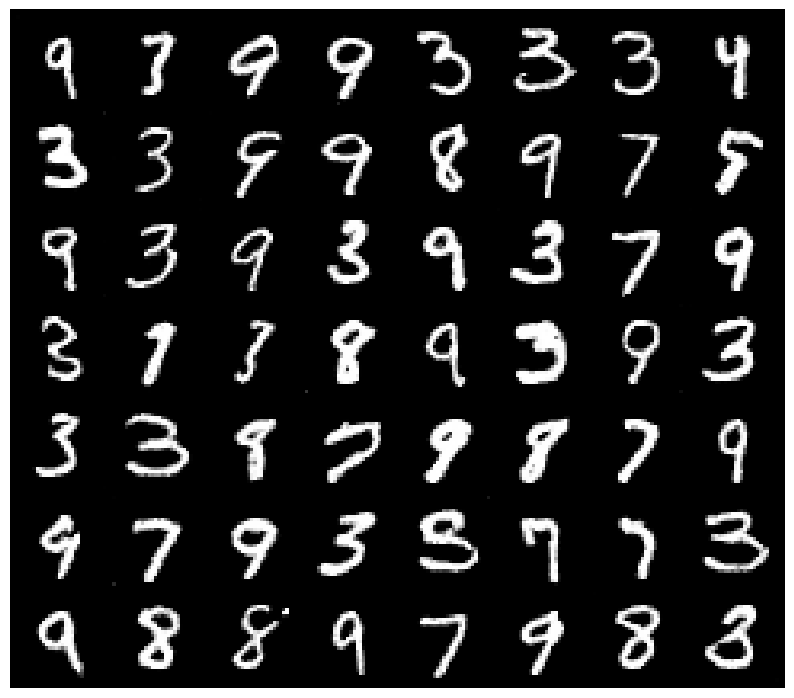

100%|█████████████████████████████████████████████████████| 732/732 [00:47<00:00, 15.47it/s, loss_D=0.576, loss_G=1.82]


Epoch [194/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [194/200] - Average D loss: 0.6185, Average G loss: 1.9891


100%|█████████████████████████████████████████████████████| 732/732 [00:32<00:00, 22.30it/s, loss_D=0.594, loss_G=1.83]


Epoch [195/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [195/200] - Average D loss: 0.6215, Average G loss: 1.9836


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.65it/s, loss_D=0.624, loss_G=2.25]


Epoch [196/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [196/200] - Average D loss: 0.6180, Average G loss: 1.9796


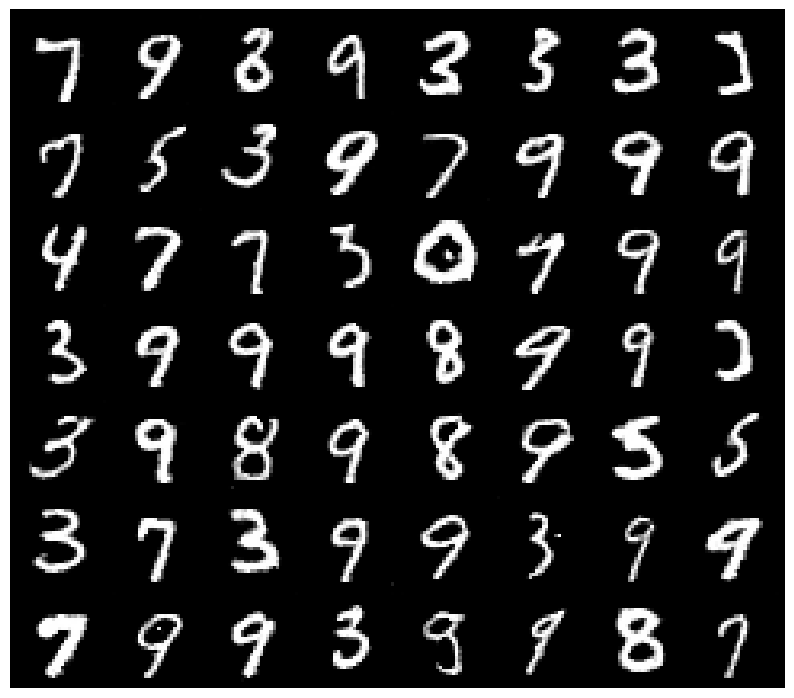

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.64it/s, loss_D=0.596, loss_G=2.18]


Epoch [197/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [197/200] - Average D loss: 0.6171, Average G loss: 1.9920


100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.71it/s, loss_D=0.482, loss_G=2.16]


Epoch [198/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [198/200] - Average D loss: 0.6189, Average G loss: 1.9805


100%|██████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.76it/s, loss_D=0.54, loss_G=2.01]


Epoch [199/200] - LR G: 0.0000137, LR D: 0.0000137
Epoch [199/200] - Average D loss: 0.6131, Average G loss: 1.9819


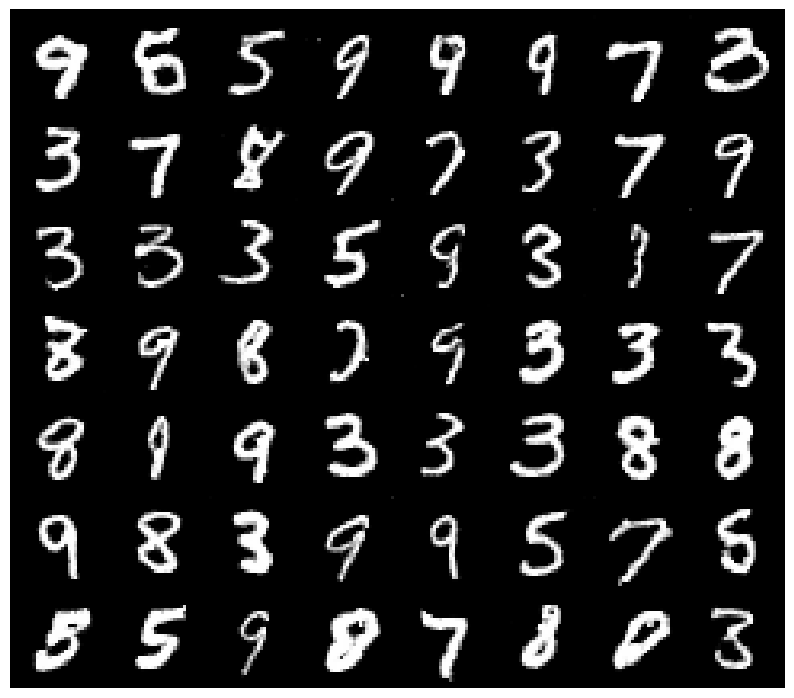

100%|█████████████████████████████████████████████████████| 732/732 [00:22<00:00, 32.73it/s, loss_D=0.522, loss_G=1.96]

Epoch [200/200] - LR G: 0.0000110, LR D: 0.0000110
Epoch [200/200] - Average D loss: 0.6167, Average G loss: 1.9838


In [15]:
def preprocess_images(images):
    normalized_images = (generated_images + 1) / 2
    display_images = (normalized_images * 255).type(torch.uint8)
    return display_images

# Initialize variables
min_g_loss = float('inf')
epochs = 200
average_d_losses = []  # List to store average discriminator losses per epoch
average_g_losses = []  # List to store average generator losses per epoch

# Assume definitions of loader_discriminator, discriminator, generator, optim_D, and optim_G

for epoch in range(epochs):
    total_d_loss = 0.0
    total_g_loss = 0.0
    count_batches = 0

    loop = tqdm(loader_discriminator, leave=True, total=len(loader_discriminator))
    for real_imgs, _ in loop:
        batch_size = real_imgs.size(0)
        real_imgs = real_imgs.to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        optim_D.zero_grad()
        real_preds = discriminator(real_imgs)
        real_loss = F.binary_cross_entropy(real_preds, real_labels)

        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_imgs = generator(noise)
        fake_preds = discriminator(fake_imgs.detach())
        fake_loss = F.binary_cross_entropy(fake_preds, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optim_D.step()

        optim_G.zero_grad()
        tricked_preds = discriminator(fake_imgs)
        g_loss = F.binary_cross_entropy(tricked_preds, real_labels)
        g_loss.backward()
        optim_G.step()

        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()
        count_batches += 1

        loop.set_postfix(loss_D=d_loss.item(), loss_G=g_loss.item())

    avg_d_loss = total_d_loss / count_batches
    avg_g_loss = total_g_loss / count_batches

    average_d_losses.append(avg_d_loss)
    average_g_losses.append(avg_g_loss)

    scheduler_G.step()
    scheduler_D.step()

    lr_G = optim_G.param_groups[0]['lr']
    lr_D = optim_D.param_groups[0]['lr']

    # Print current learning rates
    print(f"Epoch [{epoch + 1}/{epochs}] - LR G: {lr_G:.7f}, LR D: {lr_D:.7f}")
    print(f"Epoch [{epoch + 1}/{epochs}] - Average D loss: {avg_d_loss:.4f}, Average G loss: {avg_g_loss:.4f}")

    if epoch % 3 == 0:
        with torch.no_grad():
            test_noise = torch.randn(batch_size, noise_dim).to(device)
            generated_images = generator(test_noise)
            generated_images = preprocess_images(generated_images)

            plt.figure(figsize=(10, 10))
            grid = make_grid(generated_images, nrow=8)
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            plt.axis('off')
            plt.show()

torch.save(generator.state_dict(), 'best_generator.pth')

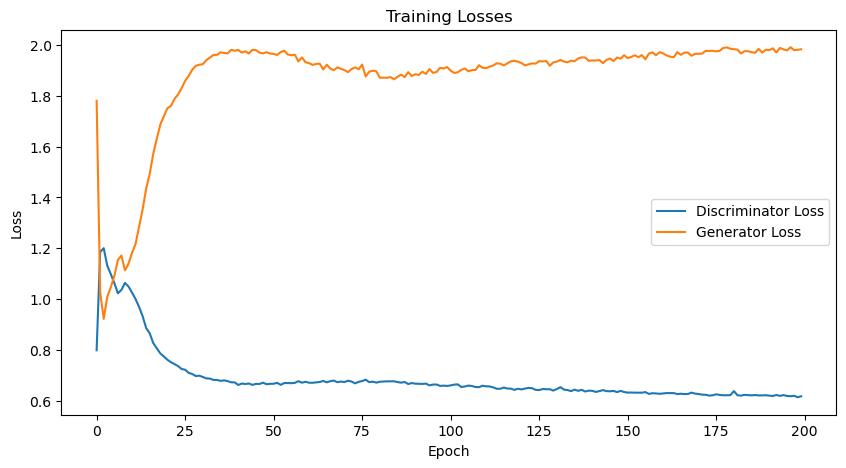

In [16]:
# Plotting the training losses
plt.figure(figsize=(10, 5))
plt.plot(average_d_losses, label='Discriminator Loss')
plt.plot(average_g_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [17]:
def calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O):
    """
    Calculate the output dimensions (height and width) of a transposed convolution layer.

    Parameters:
    H_in (int): Height of the input feature map.
    W_in (int): Width of the input feature map.
    K (int): Kernel size.
    S (int): Stride.
    P (int): Padding applied to the input.
    O (int): Output padding.

    Returns:
    tuple: (H_out, W_out) output height and width.
    """
    H_out = (H_in - 1) * S - 2 * P + K + O
    W_out = (W_in - 1) * S - 2 * P + K + O
    return H_out, W_out

# Example usage with specific parameters
H_in, W_in = 26, 26  # Example input dimensions
K = 3             # Kernel size
S = 1              # Stride
P = 0              # Padding
O = 0              # Output padding

# Calculate output dimensions
output_dims = calculate_transposed_conv_output_size(H_in, W_in, K, S, P, O)
output_dims

(28, 28)

In [18]:
def calculate_conv_output_size(input_size, kernel_size, stride, padding):
    """
    Calculate the output size of a convolutional layer.

    Args:
    input_size (tuple): The height and width of the input image (height, width).
    kernel_size (int): The size of the kernel/filter.
    stride (int): The stride of the convolution operation.
    padding (int): The padding added to the input image.

    Returns:
    tuple: The height and width of the output image (height, width).
    """
    input_height, input_width = input_size

    output_height = (input_height + 2 * padding - kernel_size) // stride + 1
    output_width = (input_width + 2 * padding - kernel_size) // stride + 1

    return (output_height, output_width)

# Example usage:
input_height = 28  # Example input height
input_width = 28   # Example input width
kernel_size = 3
stride = 2
padding = 2

output_size = calculate_conv_output_size((input_height, input_width), kernel_size, stride, padding)
print("Output size:", output_size)

Output size: (15, 15)


In [19]:
# Load the trained generator weights
generator.load_state_dict(torch.load('best_generator.pth'))
generator.eval()  # Set to evaluation mode

Generator(
  (fc): Linear(in_features=49, out_features=49, bias=True)
  (convT1): ConvTranspose2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convT4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (convT5): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(1, 1))
)

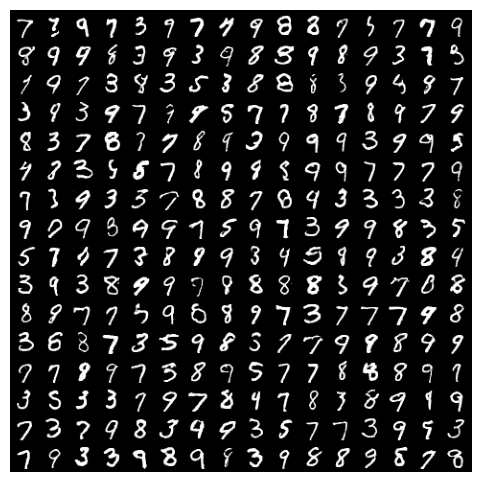

In [20]:
# Generate noise vectors
batch_size = 256  # Number of images to generate
noise = torch.randn(batch_size, noise_dim).to(device)

# Generate images from noise vectors
with torch.no_grad():
    fake_images = generator(noise)

# Assuming images are 28x28 and need to be reshaped
fake_images = fake_images.view(batch_size, 1, 28, 28)  # Reshape images to BxCxHxW format if needed
grid = make_grid(fake_images, nrow=16, normalize=True)  # Create a grid of images

# Visualize images
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())  # Adjust the channel ordering
plt.axis('off')
plt.show()
